In [ ]:
import numpy as np
from scipy.ndimage import zoom, binary_dilation
from skimage.morphology import skeletonize
import rasterio
from rasterio.plot import show
import contextily as ctx
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import os
from osgeo import gdal

# --- Schritt 1: Laden des Digitalen Höhenmodells (DEM) ---
dem_file = '/Users/evaschmidt/Documents/Preprocessing_SatelliteImagery/Geodata/merged_dem_Isar_clip.tif'
with rasterio.open(dem_file) as src:
    dem = src.read(1)
    transform = src.transform
    crs = src.crs
    bounds = src.bounds
    print(f"CRS: {crs}")  # Sollte EPSG:25832 sein
    print(f"Bounds: {bounds}")  # (links, unten, rechts, oben)
    print(f"DEM shape: {dem.shape}")

# --- Schritt 2: Maske für No-Data-Werte ---
dem = np.ma.masked_where(dem < 0, dem)  # No-Data-Werte entfernen

# --- Schritt 3: DEM-Verarbeitung und Fließwegberechnung ---
grid = Grid.from_raster(dem_file, data_type='float32')
dem_raster = grid.read_raster(dem_file)

# Füllen von Senken im DEM
pit_filled_dem = grid.fill_pits(dem_raster)

# Füllen von Überschwemmungen im DEM
flooded_dem = grid.fill_depressions(pit_filled_dem, epsilon=True)

# Auflösen von flachen Bereichen im DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Berechnen der Fließrichtungen
fdir = grid.flowdir(inflated_dem, method='dinf')

# Berechnen der Fließakkumulation
acc = grid.accumulation(fdir, method='dinf')
channels = acc > 2000  # Kanäle basierend auf Fließakkumulation (Schwellenwert anpassen)

# --- Schritt 4: Resampling der Fließwege auf die gleiche Auflösung wie NDWI ---
def resample_channels_to_ndwi(ndwi_mask, channels_mask):
    # Resampling der Fließweg-Maske, um sie mit der Auflösung der NDWI-Wasser-Maske zu kombinieren
    zoom_factor = (ndwi_mask.shape[0] / channels_mask.shape[0], ndwi_mask.shape[1] / channels_mask.shape[1])
    return zoom(channels_mask, zoom_factor, order=1)  # Bilineare Interpolation

# --- Schritt 5: Wasser-Masken und Fließwege kombinieren ---
def combine_water_mask_with_channels(water_mask, channels_mask):
    # Kombinieren der NDWI-Wasser-Maske mit den Fließwegen
    return np.logical_or(water_mask, channels_mask)

# --- Schritt 6: Gap-Fixing und kontinuierliche Fließwege ---
def gap_fixing_and_skeletonization(combined_mask, max_gap_distance=5):
    # Gap-Fixing und Erzeugen der kontinuierlichen Fließwege
    gap_kernel = np.ones((max_gap_distance, max_gap_distance))
    combined_dilated = binary_dilation(combined_mask, structure=gap_kernel)
    return skeletonize(combined_dilated)

# --- Schritt 7: Visualisierung der Ergebnisse ---
def visualize_results(combined_mask, fixed_rivers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(combined_mask, cmap='Greys')
    ax1.set_title('Original Combined Mask')
    ax2.imshow(fixed_rivers, cmap='Greys')
    ax2.set_title(f'Fixed Rivers (Max Gap={max_gap_distance}px)')
    plt.savefig("river_coverage_alternative2.png")
    plt.show()

# --- Schritt 8: Durchlaufen der NDWI-Bilder und Fließwege ---
def process_images_and_combine_masks(image_folder, channels_mask):
    # Durchlaufe alle vorverarbeiteten NDWI-Bilder im angegebenen Ordner
    for filename in os.listdir(image_folder):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            file_path = os.path.join(image_folder, filename)
            try:
                print(f"\nProcessing file: {filename}")

                # Öffnen der NDWI-Bilddatei
                dataset = gdal.Open(file_path)
                if dataset is None:
                    print(f"Could not open file: {filename}")
                    continue

                # NDWI-Maske extrahieren (erste Band)
                band = dataset.GetRasterBand(1)
                ndwi_mask = band.ReadAsArray()

                # Fließwege auf die gleiche Auflösung wie NDWI resamplen
                resampled_channels = resample_channels_to_ndwi(ndwi_mask, channels_mask)

                # Wasser-Maske mit Fließwegen kombinieren
                combined_mask = combine_water_mask_with_channels(ndwi_mask, resampled_channels)

                # Gap-Fixing und kontinuierliche Fließwege erstellen
                fixed_rivers = gap_fixing_and_skeletonization(combined_mask)

                # Visualisierung der Ergebnisse
                visualize_results(combined_mask, fixed_rivers)

                # Speicherung der finalen Fließweg-Maske als GeoTIFF
                save_river_mask_as_geotiff(fixed_rivers, dataset, filename)

            except Exception as e:
                print(f"Error processing file {filename}: {str(e)}")

# --- Schritt 9: Speichern der Fließweg-Maske als GeoTIFF ---
def save_river_mask_as_geotiff(river_mask, dataset, filename):
    output_filename = f"/path/to/output/fixed_rivers_{filename}"
    driver = gdal.GetDriverByName('GTiff')
    out_dataset = driver.Create(
        output_filename,
        dataset.RasterXSize,
        dataset.RasterYSize,
        1,
        gdal.GDT_Byte
    )
    out_dataset.SetGeoTransform(dataset.GetGeoTransform())
    out_dataset.SetProjection(dataset.GetProjection())
    out_band = out_dataset.GetRasterBand(1)
    out_band.WriteArray(river_mask.astype(np.uint8))
    out_dataset = None
    print(f"Saved river mask to {output_filename}")

# --- Hauptaufruf: Images und Fließwege kombinieren ---
image_folder = '/Users/evaschmidt/Documents/Preprocessing_SatelliteImagery/GEE_Images_Isar'
process_images_and_combine_masks(image_folder, channels)


CRS: EPSG:25832
Bounds: BoundingBox(left=683396.0, bottom=5269723.0, right=687396.0, top=5270723.0)
DEM shape: (1000, 4000)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/evaschmidt/Documents/Preprocessing_SatelliteImagery/NDWI_images_folder'

In [9]:
import pandas as pd

# Lade deine bestehende CSV-Datei
metadata_path = 'Metadata.csv'  # Pfad zu deiner Metadata.csv-Datei
metadata_df = pd.read_csv(metadata_path)

# Erstelle eine neue Spalte 'Index' mit aufsteigenden Werten beginnend bei 0
metadata_df['Index'] = range(len(metadata_df))

# Speichern der Datei mit der neuen Index-Spalte
output_path = 'Metadata_with_index.csv'  # Pfad zum Speichern der neuen CSV-Datei
metadata_df.to_csv(output_path, index=False)

print(f"Neue Spalte 'Index' hinzugefügt und gespeichert unter: {output_path}")


Neue Spalte 'Index' hinzugefügt und gespeichert unter: Metadata_with_index.csv


Saved water mask: water_masks/water_mask_NDWI_7.tif
Verarbeitetes Bild NDWI_7.tif, Zeitstempel: 2020-05-06
Saved water mask: water_masks/water_mask_NDWI_34.tif
Verarbeitetes Bild NDWI_34.tif, Zeitstempel: 2020-11-07
Saved water mask: water_masks/water_mask_NDWI_20.tif
Verarbeitetes Bild NDWI_20.tif, Zeitstempel: 2020-07-30
Saved water mask: water_masks/water_mask_NDWI_21.tif
Verarbeitetes Bild NDWI_21.tif, Zeitstempel: 2020-08-01
Saved water mask: water_masks/water_mask_NDWI_35.tif
Verarbeitetes Bild NDWI_35.tif, Zeitstempel: 2020-11-09
Saved water mask: water_masks/water_mask_NDWI_6.tif
Verarbeitetes Bild NDWI_6.tif, Zeitstempel: 2020-04-23
Saved water mask: water_masks/water_mask_NDWI_4.tif
Verarbeitetes Bild NDWI_4.tif, Zeitstempel: 2020-04-11
Saved water mask: water_masks/water_mask_NDWI_23.tif
Verarbeitetes Bild NDWI_23.tif, Zeitstempel: 2020-08-09
Saved water mask: water_masks/water_mask_NDWI_37.tif
Verarbeitetes Bild NDWI_37.tif, Zeitstempel: 2020-11-17
Saved water mask: water_m

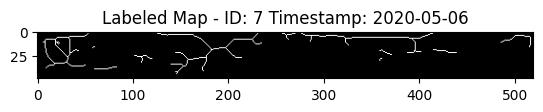

In [13]:
import os
import numpy as np
import pandas as pd
from osgeo import gdal
from scipy.ndimage import zoom, binary_dilation
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from pysheds.grid import Grid

# Schritt 1: Funktion zum Extrahieren der ID aus dem Dateinamen (z.B. "NDWI_06.tif" -> ID 06)
def extract_id_from_filename(filename):
    return int(filename.split('_')[1].split('.')[0])  # Extrahiert die ID aus dem Dateinamen

# Schritt 2: Funktion, um den Timestamp aus einer CSV-Datei anhand der ID zu holen
def get_timestamp_from_id(image_id):
    timestamp_data = pd.read_csv('Metadata_with_index.csv')  # Pfad zur CSV-Datei mit Timestamps
    row = timestamp_data[timestamp_data['Index'] == image_id]
    if not row.empty:
        return row['timestamp'].values[0]
    else:
        return None  # Falls keine passende ID gefunden wurde

# Schritt 3: Extrahieren der Channels aus dem DEM
def extract_channels_from_dem(dem_file_path):
    # Lade das DEM mit pysheds
    grid = Grid.from_raster(dem_file_path, data_type='float32')
    dem_raster = grid.read_raster(dem_file_path)
    
    # Fülle Vertiefungen und Löcher im DEM (Pit Filling)
    pit_filled_dem = grid.fill_pits(dem_raster)

    # Fülle Senken (Depressionsfüllung)
    flooded_dem = grid.fill_depressions(pit_filled_dem, epsilon=True)
    
    # Berechne Fließrichtung basierend auf dem DEM
    fdir = grid.flowdir(flooded_dem, method='dinf')
    
    # Berechne die Fließakkumulation
    acc = grid.accumulation(fdir, method='dinf')
    
    # Erstelle Fließkanäle, indem man eine Akkumulationsschwelle anwendet
    channels = acc > 2000  # Beispielhafte Schwelle; diese muss je nach DEM-Auflösung und Region angepasst werden
    
    return channels

# Schritt 4: Verarbeiten der Watermasks und der Fließwege (Channels)
def process_images_and_create_labeled_maps(folder_path, channels, output_folder):
    labeled_maps = []

    output_dir_water_masks = 'water_masks/'  # Ordner für Wasser-Masken

    # Iteriere über die Bilder im Ordner
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.tif', '.tiff')):
            # Extrahieren der ID und des Timestamps
            image_id = extract_id_from_filename(filename)
            timestamp = get_timestamp_from_id(image_id)
            if timestamp is None:
                print(f"Kein Timestamp gefunden für Bild {filename}. Überspringe.")
                continue
            
            # Öffne das Bild
            file_path = os.path.join(folder_path, filename)
            dataset = gdal.Open(file_path)
            if dataset is None:
                print(f"Fehler beim Öffnen der Datei: {filename}")
                continue
            
            # Hole das NDWI-Band (erste Band)
            band = dataset.GetRasterBand(1)
            ndwi = band.ReadAsArray()
            
            water_mask = ndwi > -0.05  # Beispielhafte Schwelle für Wasser (NDWI)
        
            # Save the water mask before combining with channels
            water_mask_filename = os.path.join(output_dir_water_masks, f"water_mask_{os.path.splitext(filename)[0]}.tif")
            driver = gdal.GetDriverByName('GTiff')
            mask_dataset = driver.Create(
                water_mask_filename,
                dataset.RasterXSize,
                dataset.RasterYSize,
                1,
                gdal.GDT_Byte
            )
            mask_dataset.SetGeoTransform(dataset.GetGeoTransform())
            mask_dataset.SetProjection(dataset.GetProjection())
            mask_band = mask_dataset.GetRasterBand(1)
            mask_band.WriteArray(water_mask.astype(np.uint8))
            mask_dataset = None
            print(f"Saved water mask: {water_mask_filename}")


            # Resample Channels, um sie mit dem NDWI-Bild zu kombinieren
            zoom_factor = (ndwi.shape[0] / channels.shape[0], ndwi.shape[1] / channels.shape[1])
            channels_resampled = zoom(channels, zoom_factor, order=1)
            
            # Kombiniere die Masken (NDWI und Fließwege)
            combined_mask = np.logical_or(ndwi > -0.05, channels_resampled > 0)
            
            # Gap Fixing (z.B. Lücken in den Fließwegen schließen)
            max_gap_distance = 5
            gap_kernel = np.ones((max_gap_distance, max_gap_distance))
            continuous_rivers = skeletonize(binary_dilation(combined_mask, structure=gap_kernel))
            
            # Speichere die kombinierte Watermask als Labeled Map
            labeled_maps.append((image_id, timestamp, continuous_rivers))  # Timestamp wird hier hinzugefügt

            # Optional: Speichern der kombinierten Map als Bild oder GeoTIFF
            output_filename = os.path.join(output_folder, f"labeled_{image_id}.tif")
            driver = gdal.GetDriverByName('GTiff')
            out_dataset = driver.Create(output_filename, dataset.RasterXSize, dataset.RasterYSize, 1, gdal.GDT_Byte)
            out_dataset.SetGeoTransform(dataset.GetGeoTransform())
            out_dataset.SetProjection(dataset.GetProjection())
            out_band = out_dataset.GetRasterBand(1)
            out_band.WriteArray(continuous_rivers.astype(np.uint8))
            out_dataset = None
            
            print(f"Verarbeitetes Bild {filename}, Zeitstempel: {timestamp}")
    
    # Konvertiere das Array mit allen Labeled Maps in ein NumPy Array
    labeled_maps_array = np.array([map[2] for map in labeled_maps])

    # Falls du auch die Timestamps und IDs in einer Tabelle haben möchtest:
    labeled_maps_df = pd.DataFrame(labeled_maps, columns=['ID', 'Timestamp', 'Labeled Map'])

    # Optional: Speichern der Tabelle mit den IDs, Zeitstempeln und den Labels als CSV
    labeled_maps_df.to_csv(os.path.join(output_folder, 'labeled_maps_with_timestamps.csv'), index=False)

    print("Alle Watermasks wurden verarbeitet und gespeichert.")
    return labeled_maps_df, labeled_maps_array


# Schritt 5: Beispielaufruf der Funktion (benutze deinen spezifischen Ordner und die Pfade)
folder_path = 'GEE_Images_Isar/'  # Pfad zu den Satellitenbildern
dem_file_path = 'Geodata/merged_dem_Isar_clip.tif'  # Pfad zu deinem DEM (Merged DEM)
output_folder = 'Labeled_Maps_Isar/'  # Pfad zum Ausgabeordner für Labeled Maps

# Extrahiere die Channels aus dem DEM
channels = extract_channels_from_dem(dem_file_path)

# Verarbeite die Bilder und erstelle die Labeled Maps
labeled_maps_df, labeled_maps_array = process_images_and_create_labeled_maps(folder_path, channels, output_folder)

# Optional: Visualisiere die Ergebnisse
# Hier kannst du die Labeled Maps als Beispiel anzeigen
plt.imshow(labeled_maps_array[0], cmap='gray')
plt.title(f"Labeled Map - ID: {labeled_maps_df['ID'][0]} Timestamp: {labeled_maps_df['Timestamp'][0]}")
plt.show()


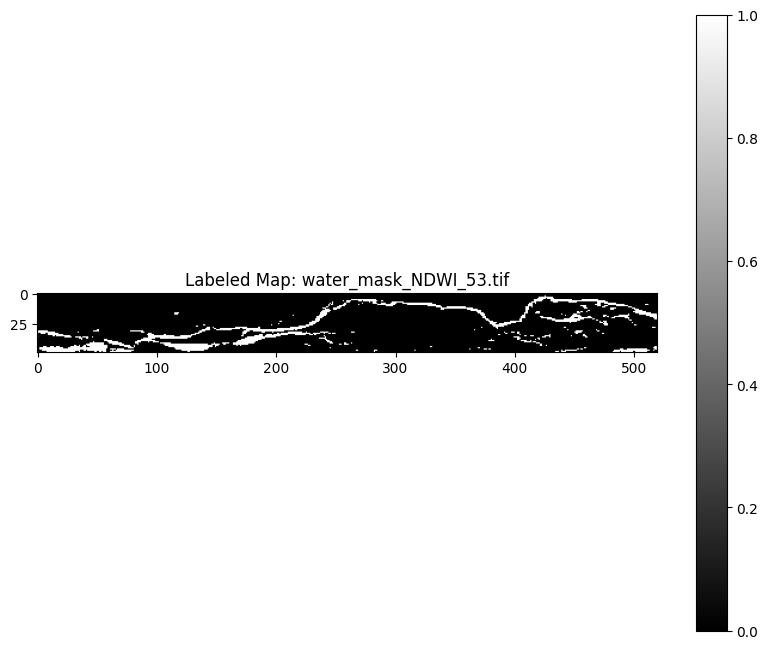

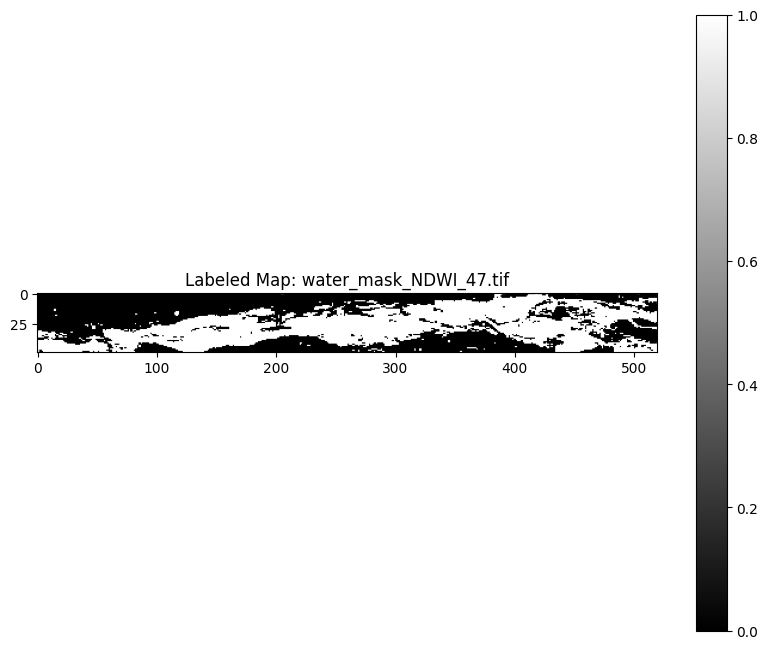

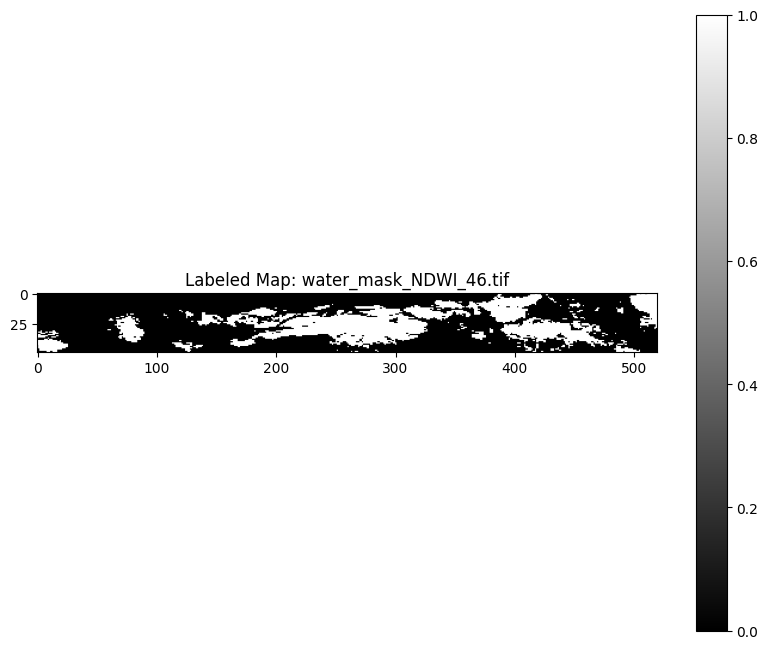

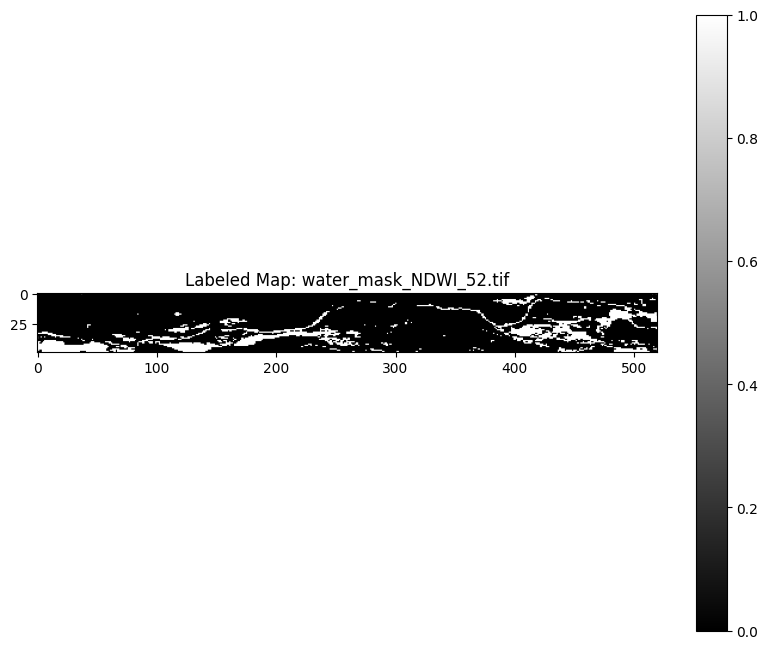

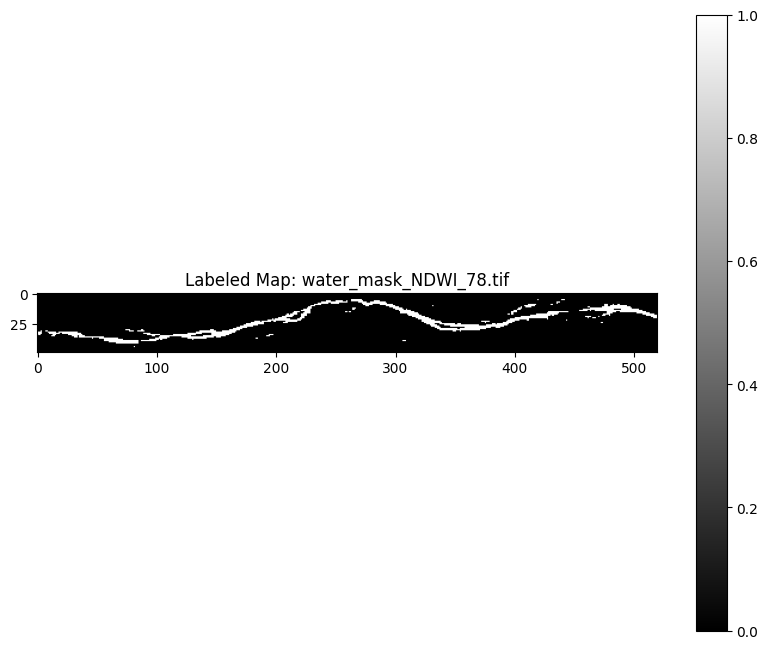

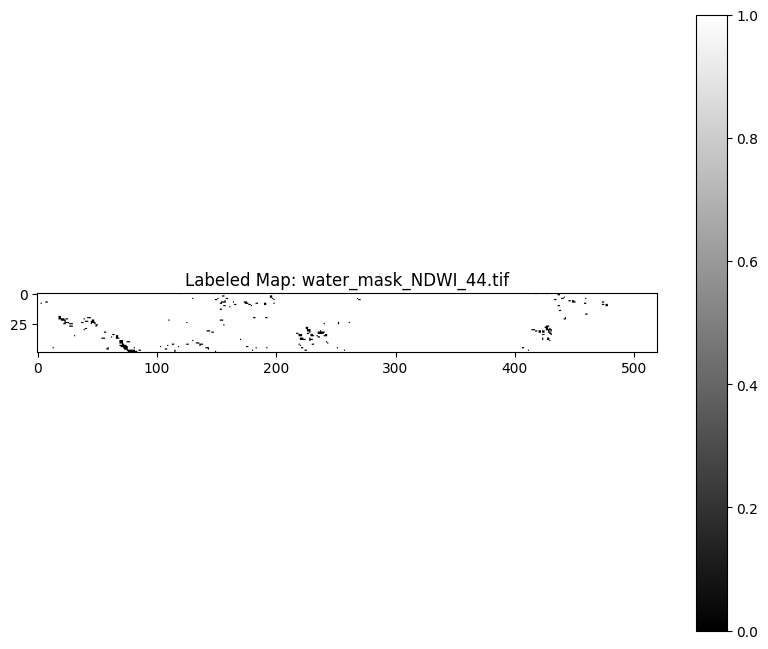

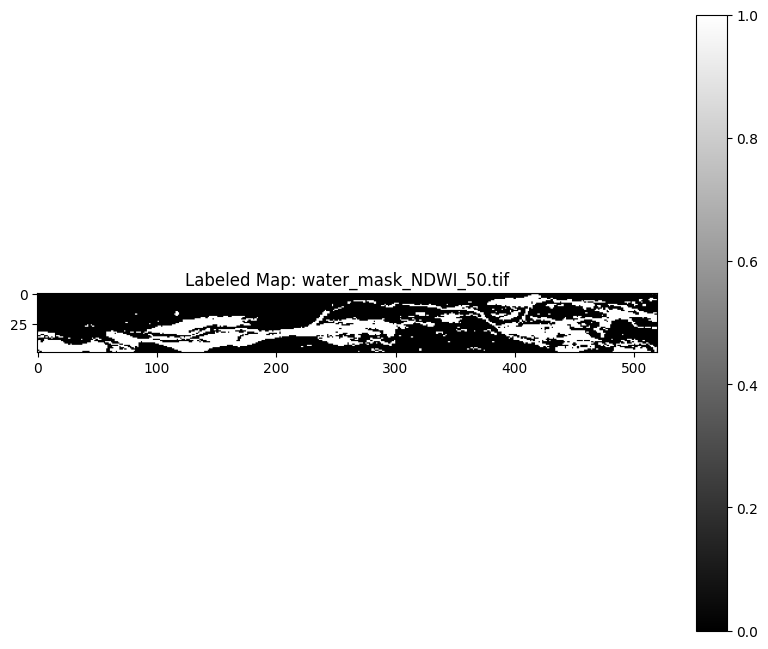

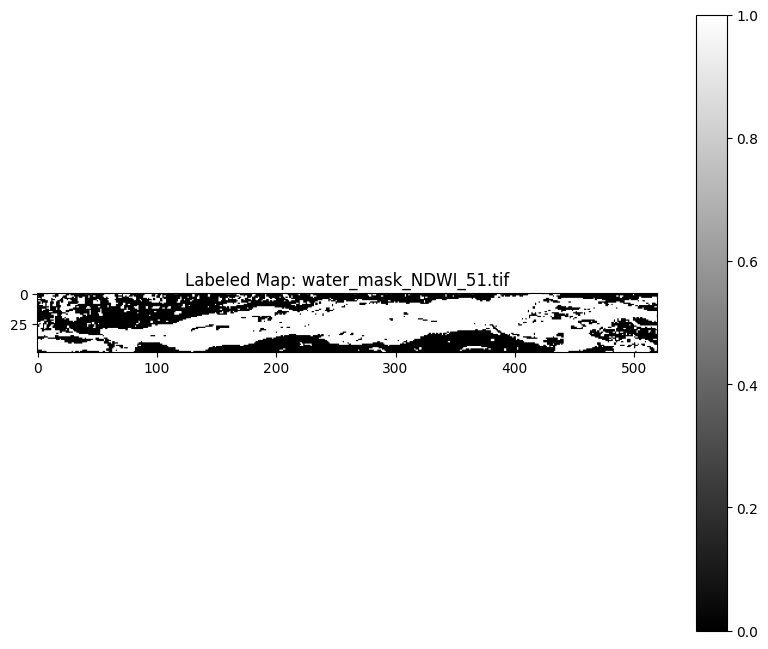

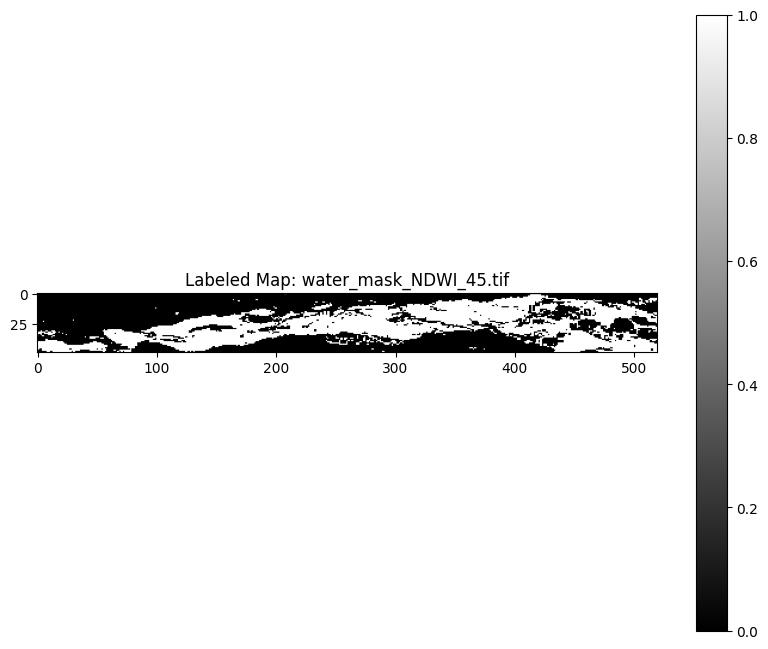

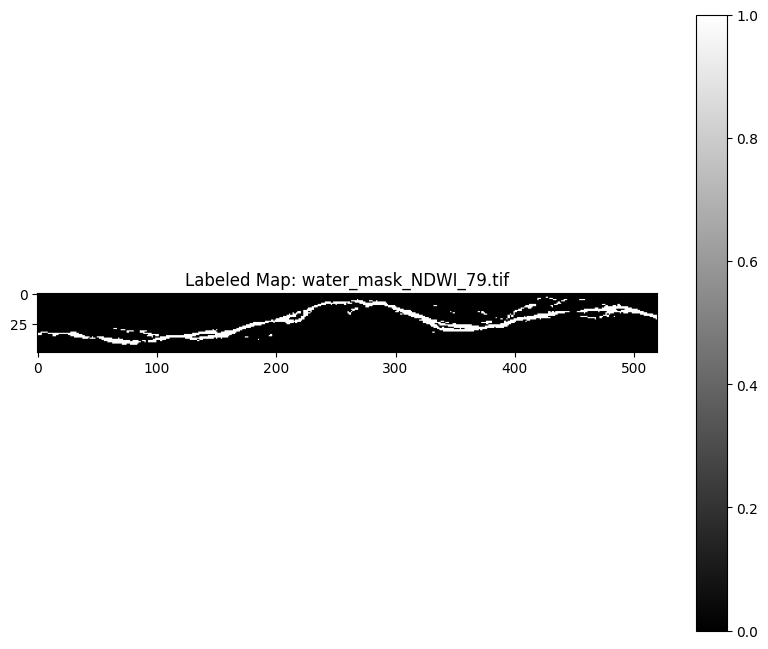

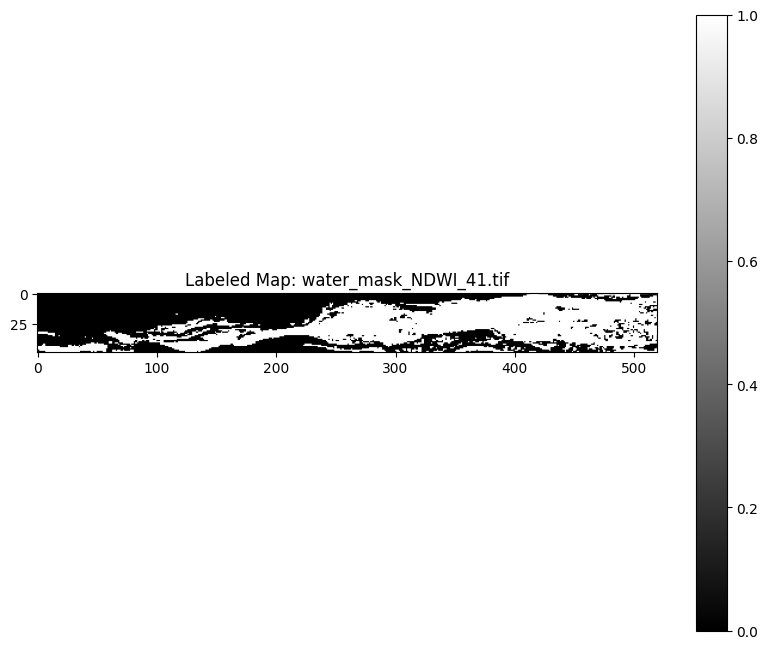

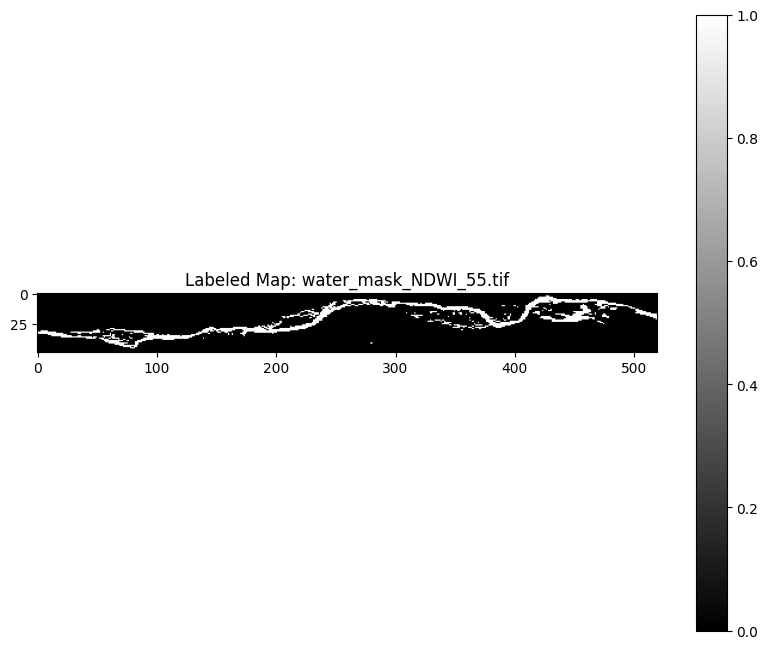

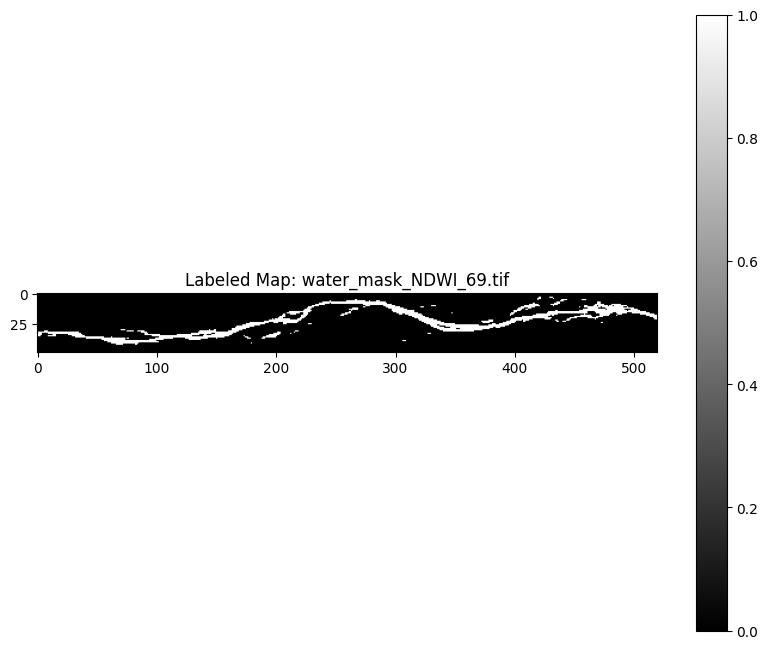

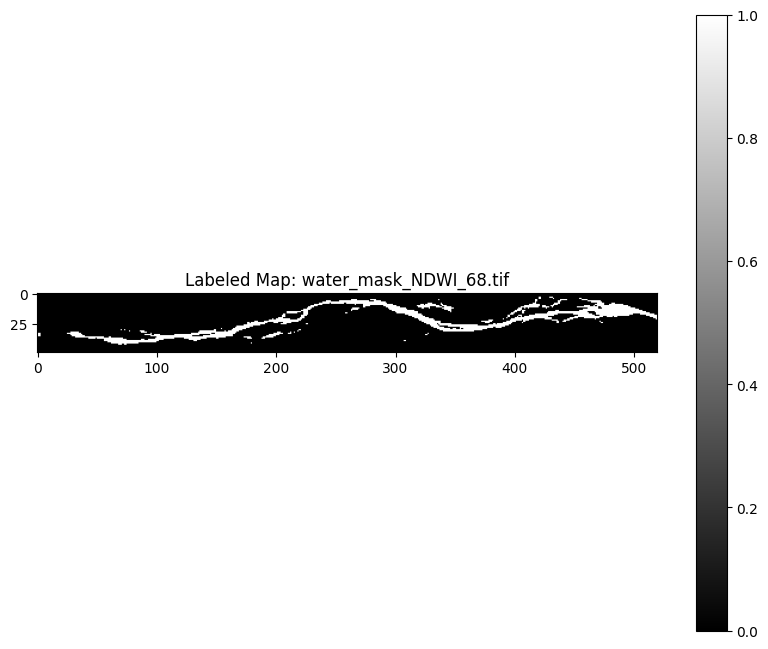

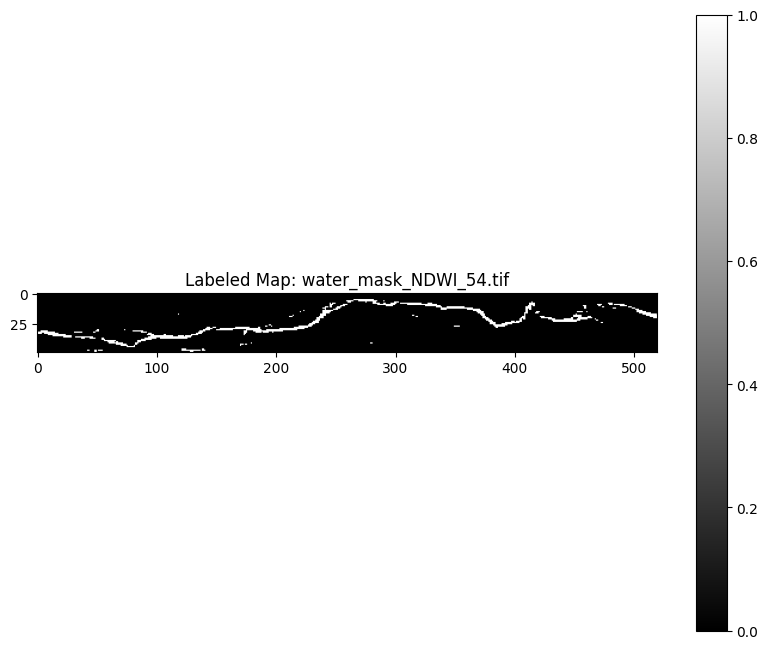

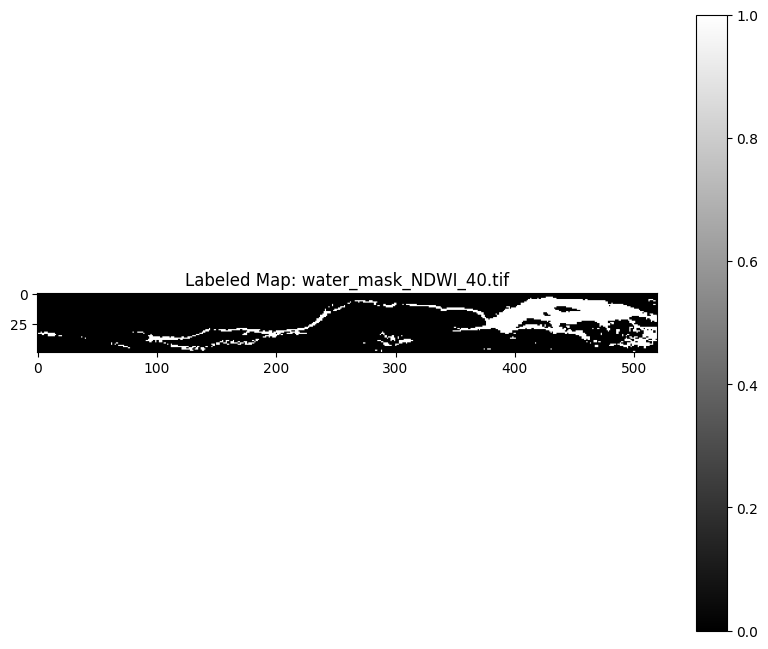

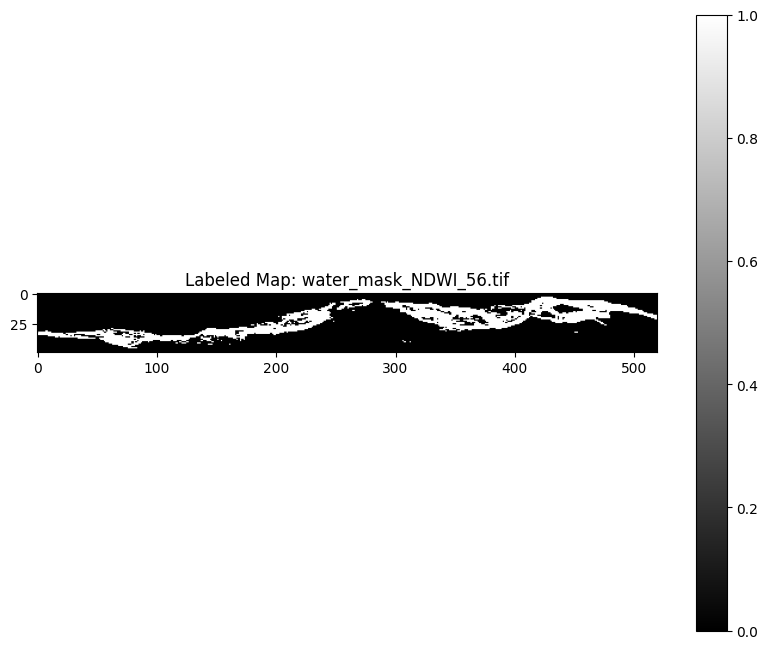

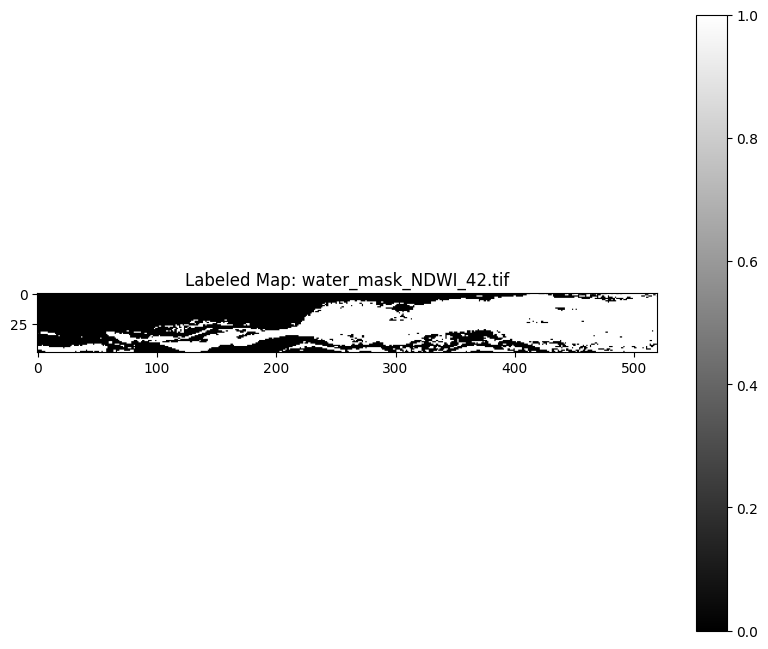

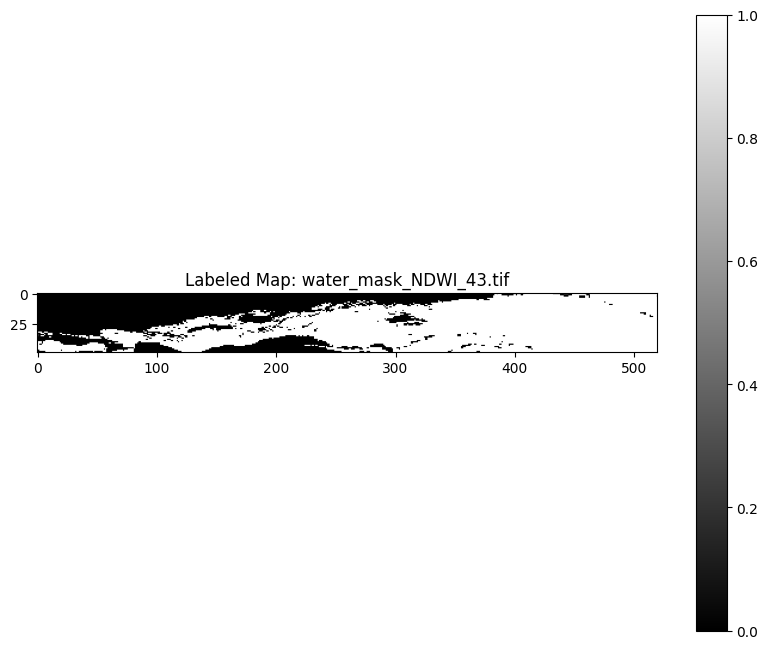

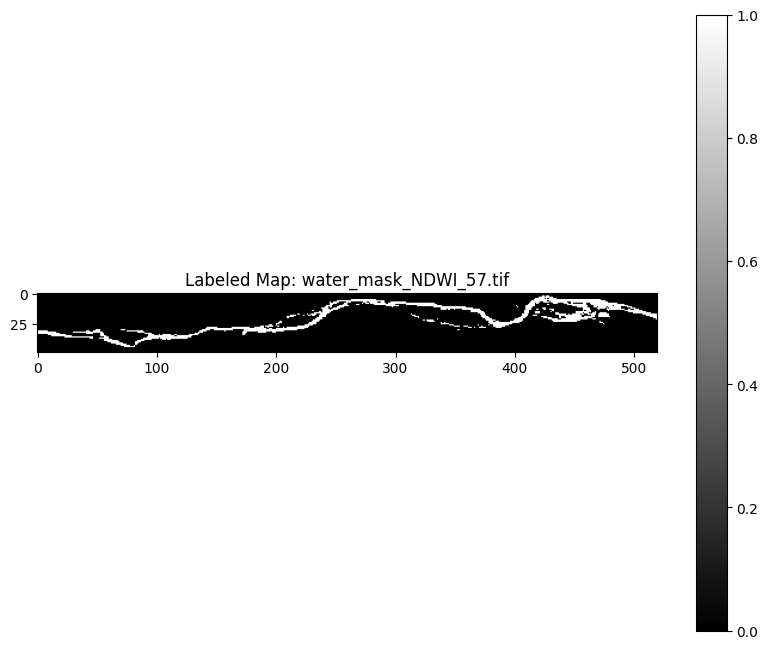

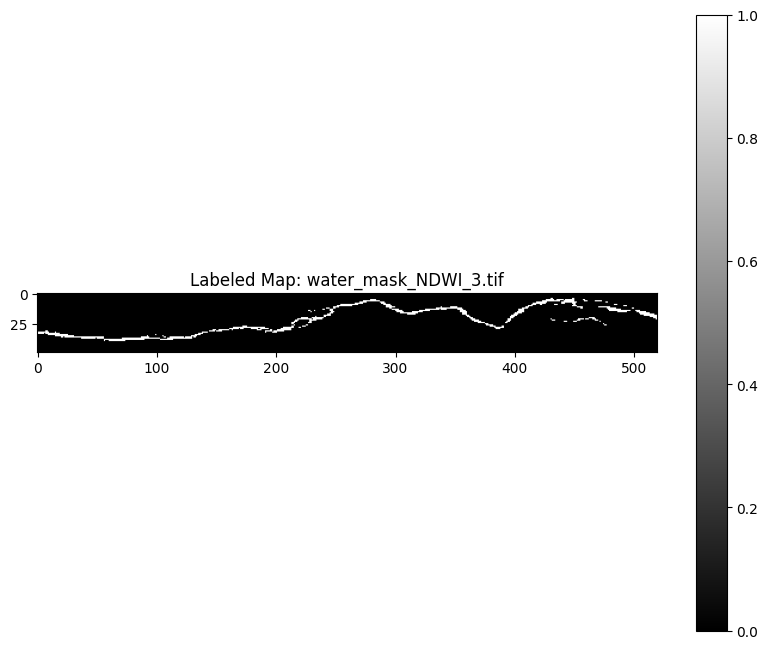

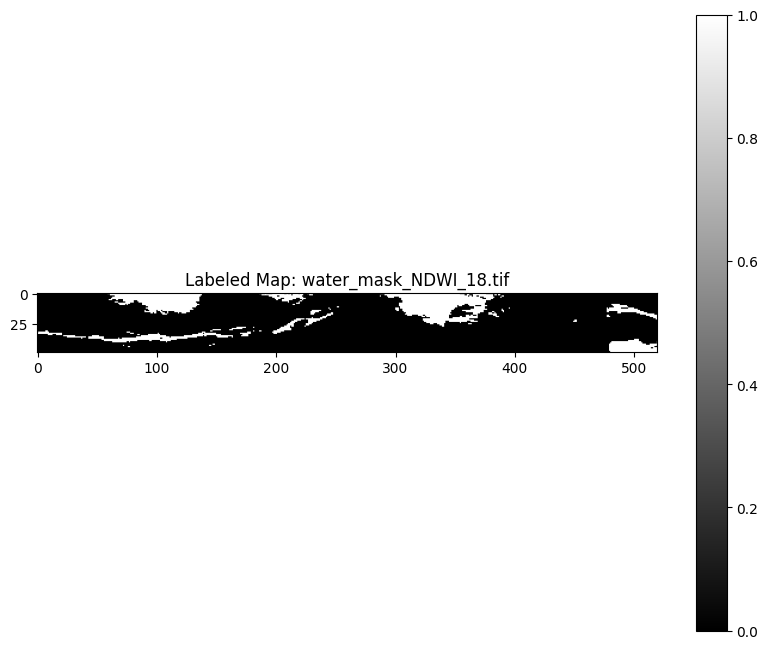

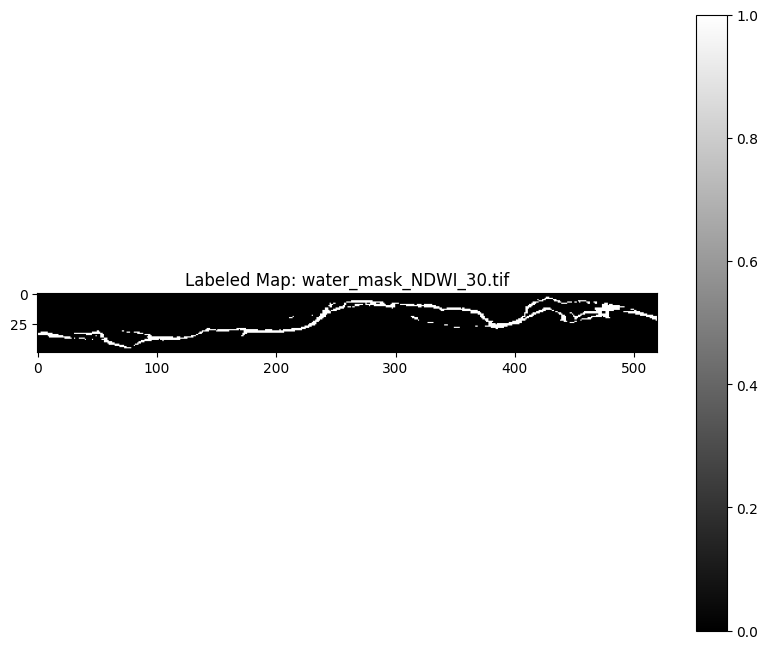

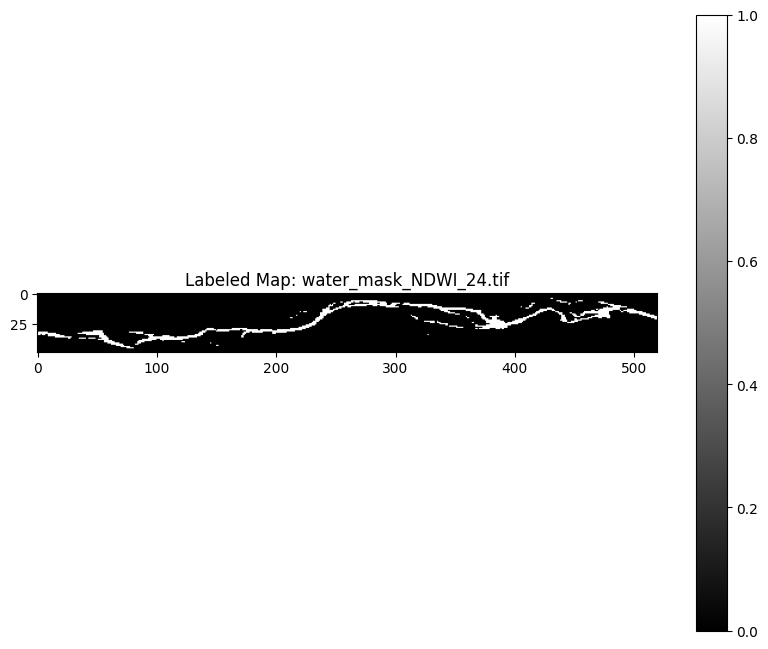

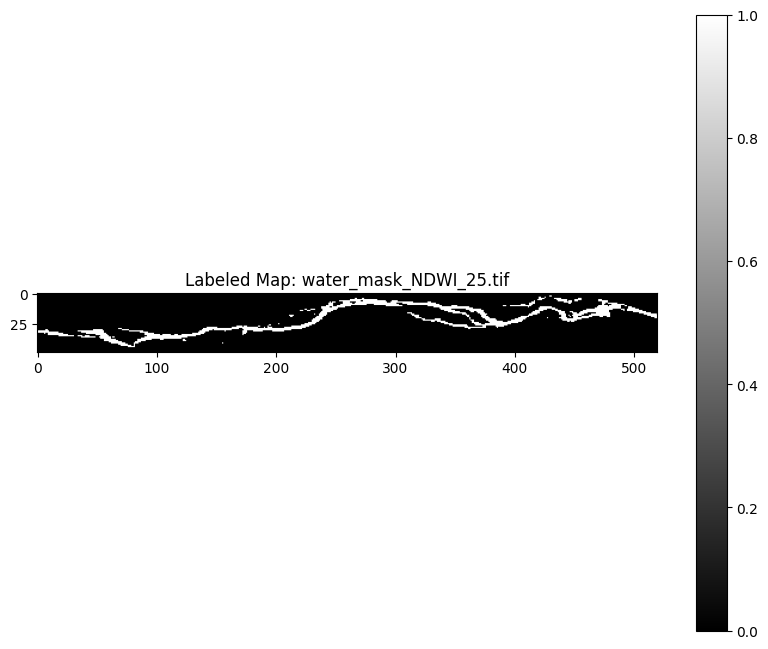

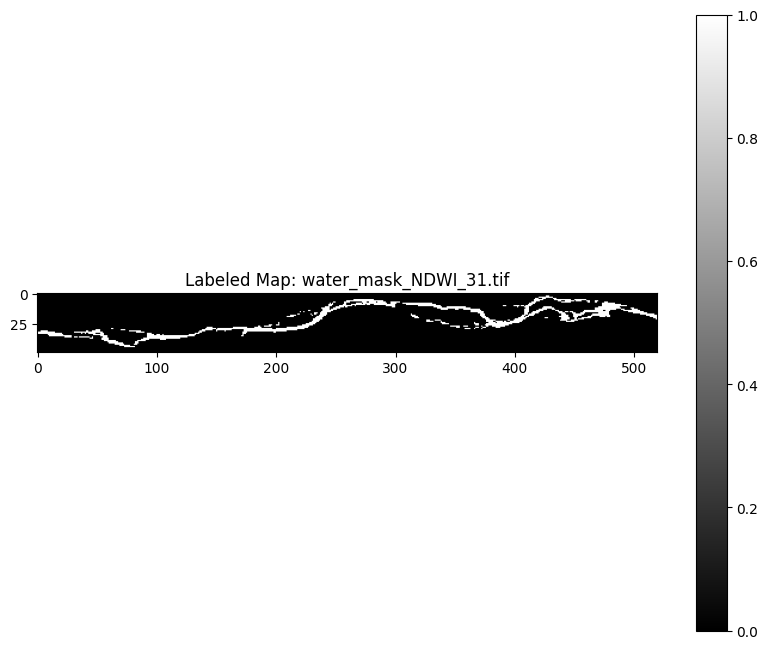

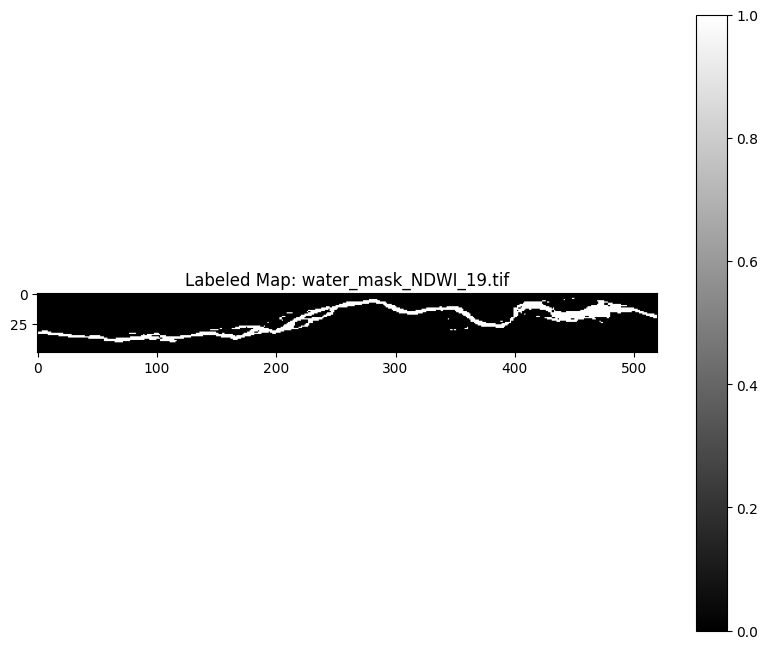

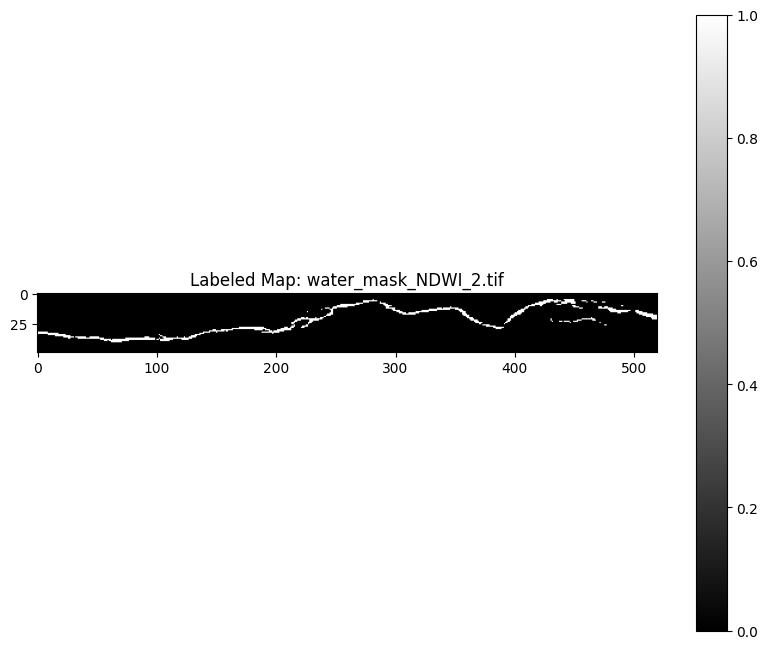

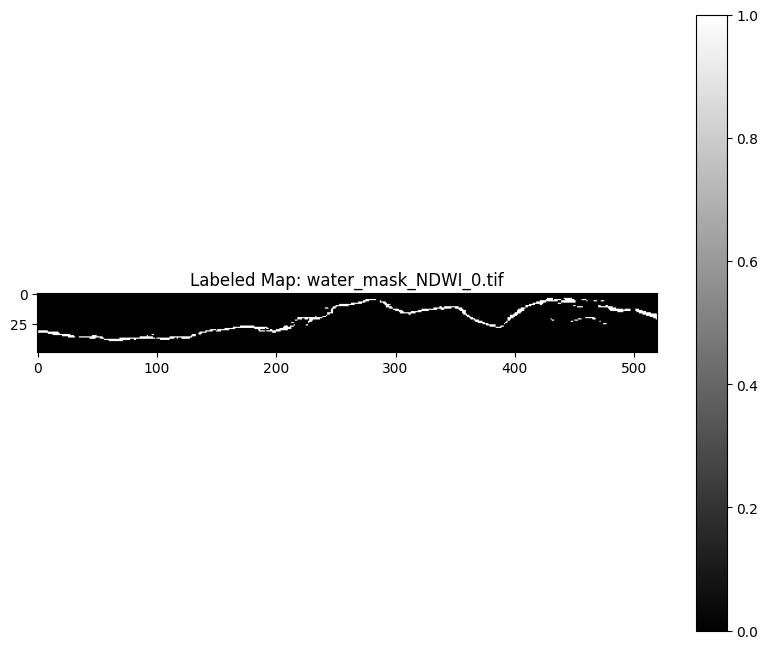

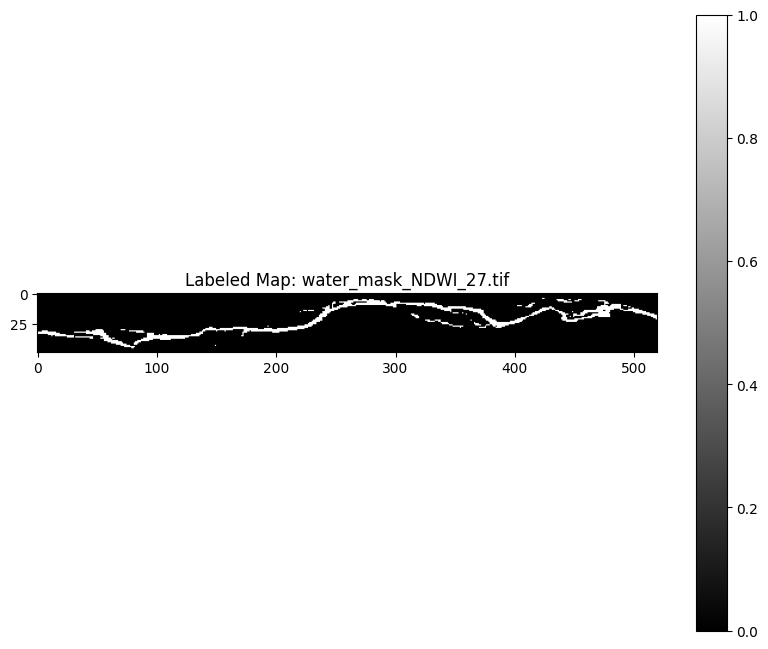

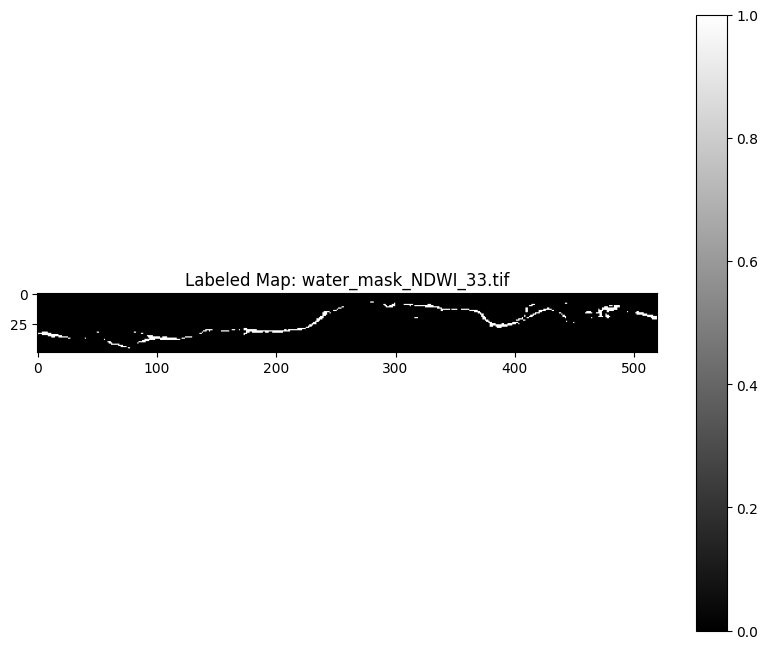

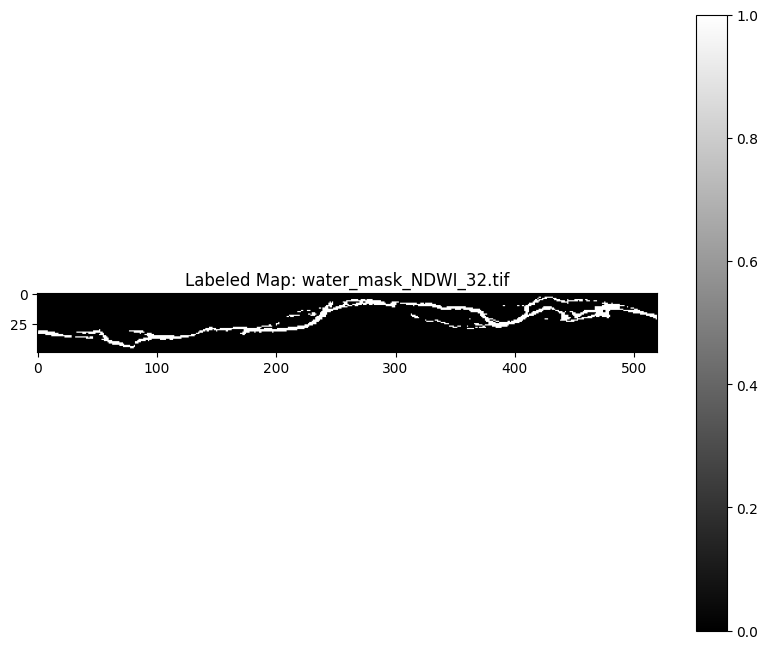

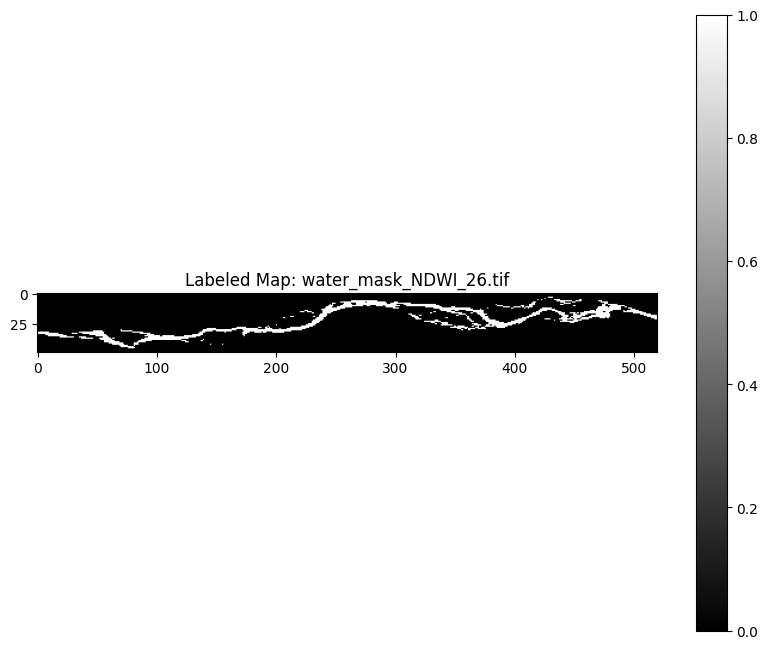

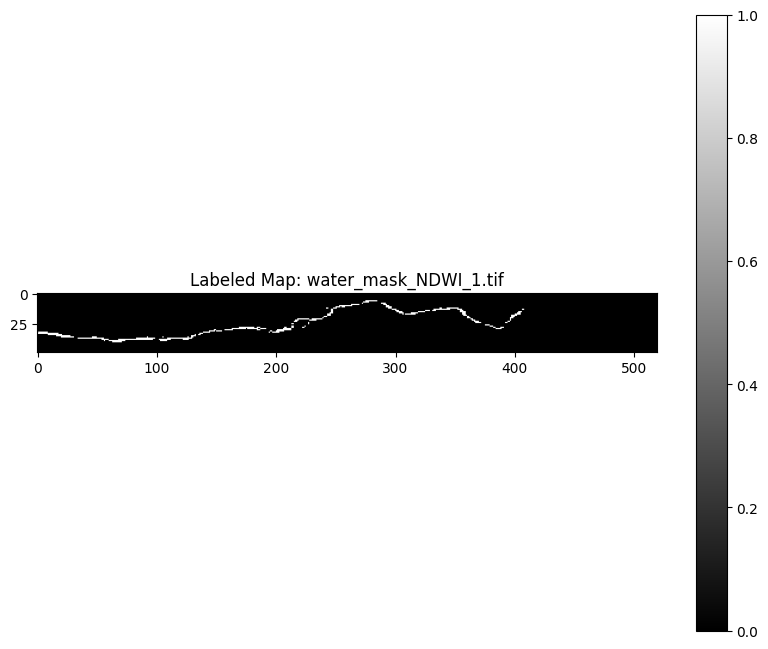

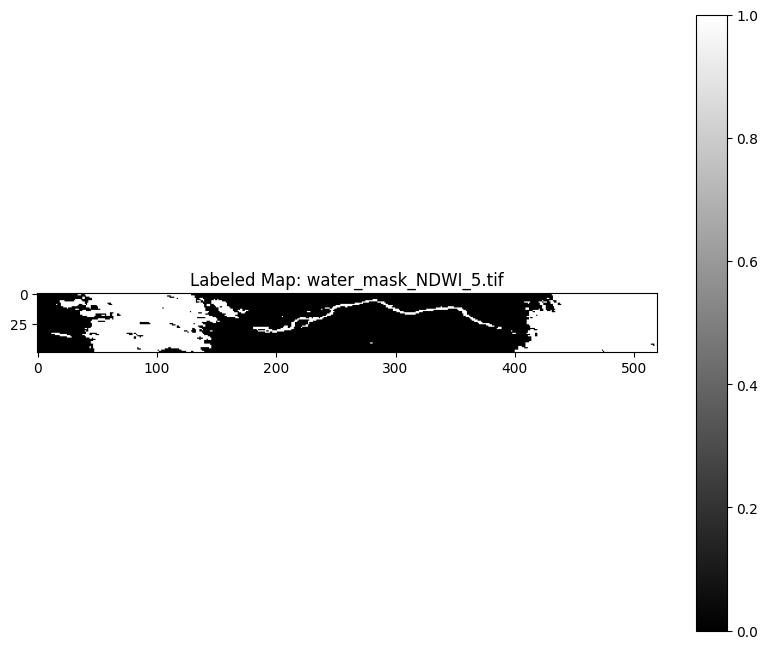

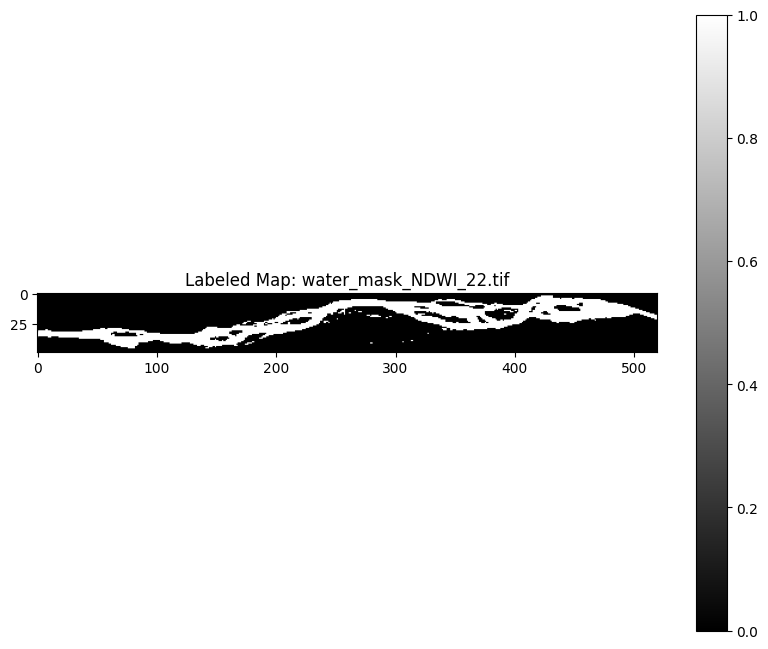

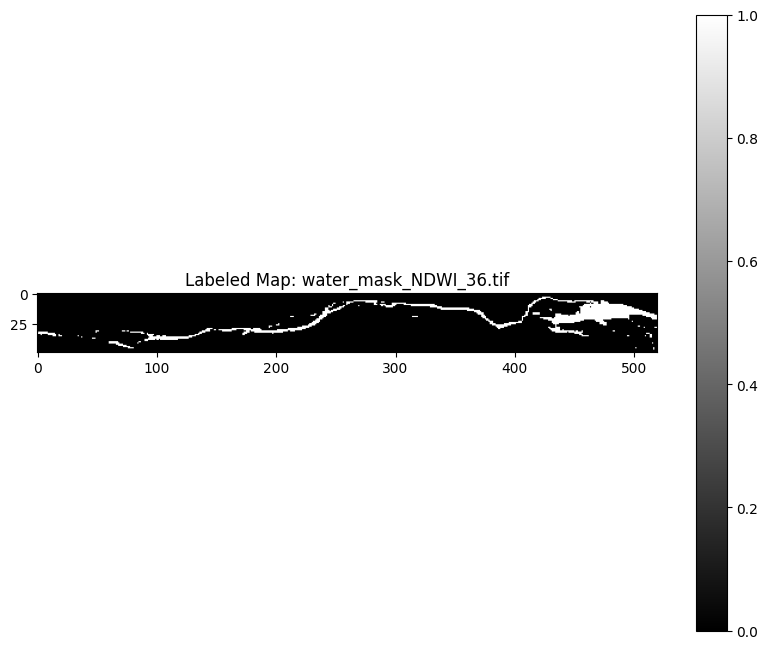

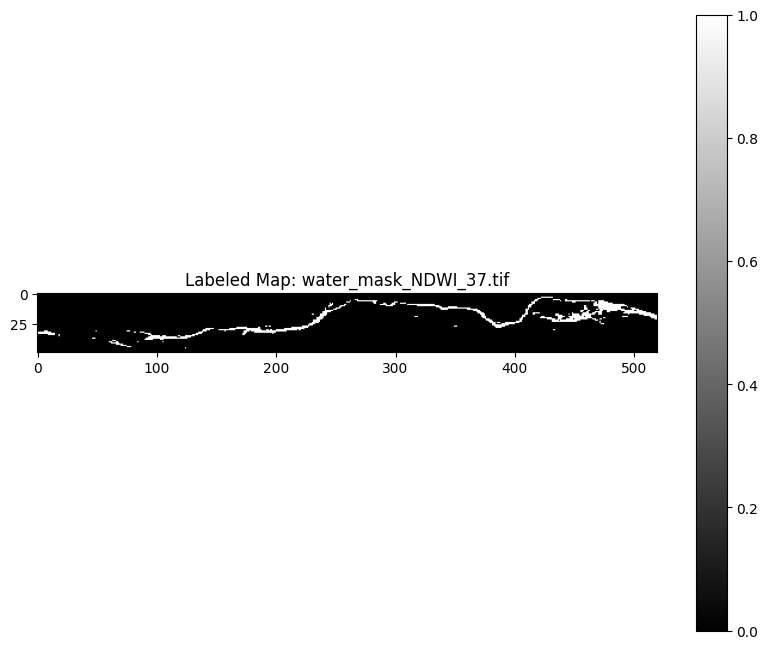

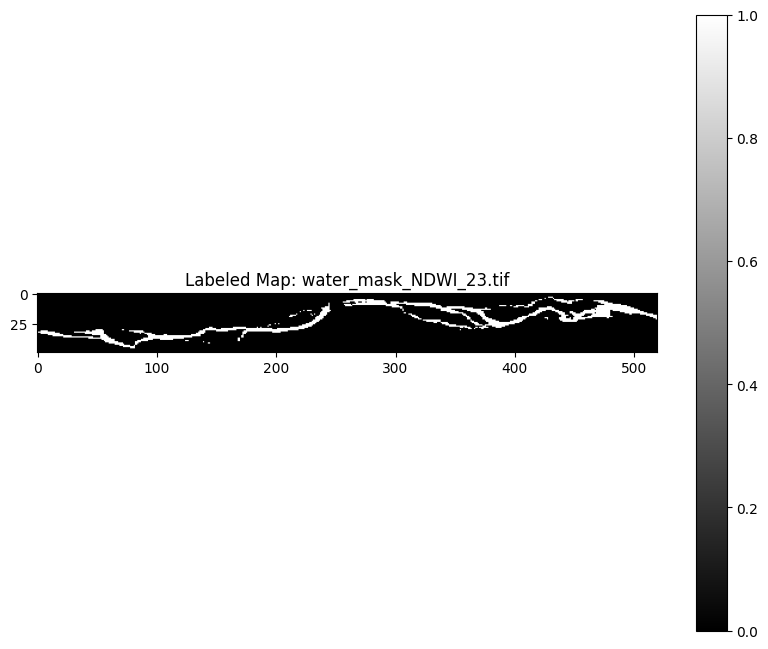

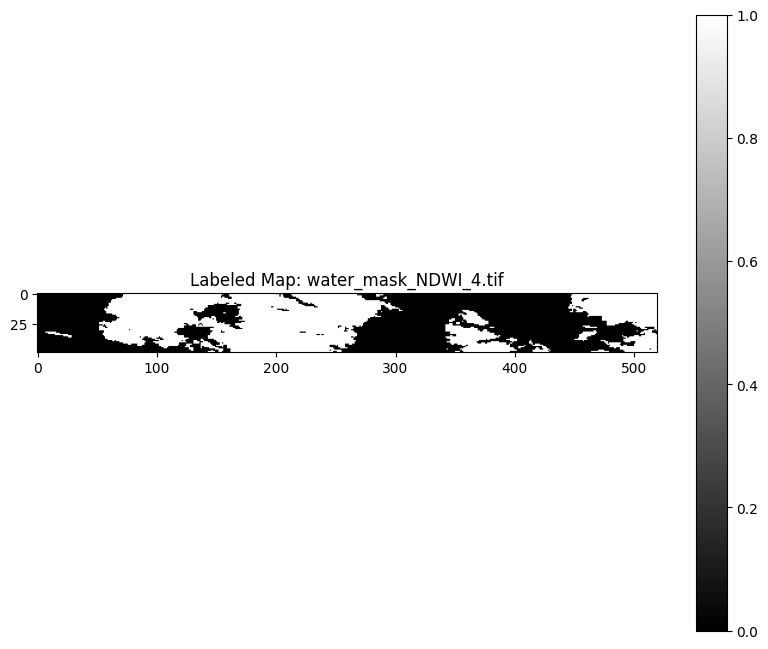

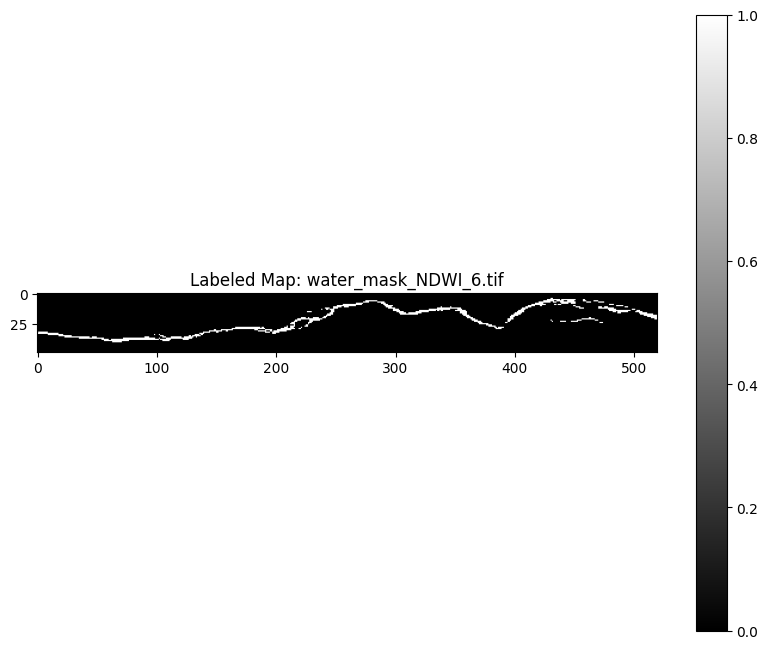

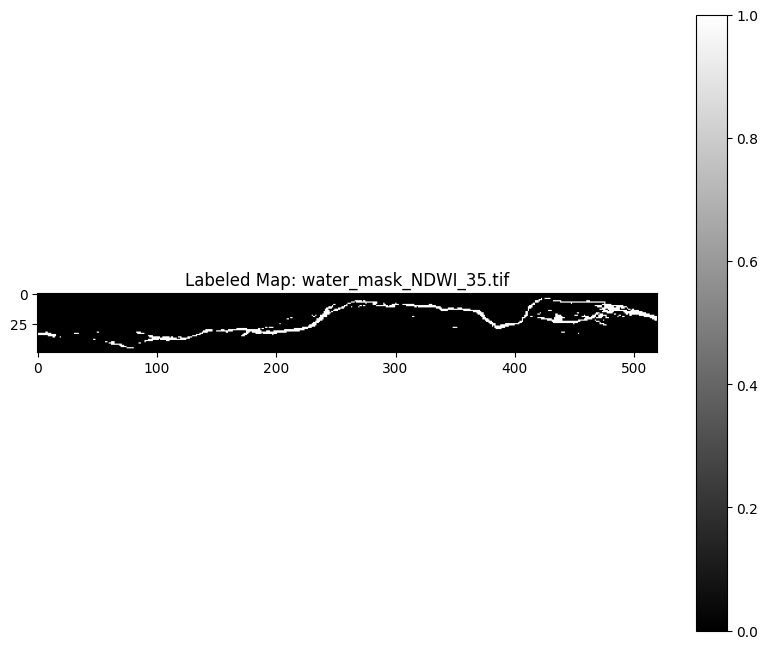

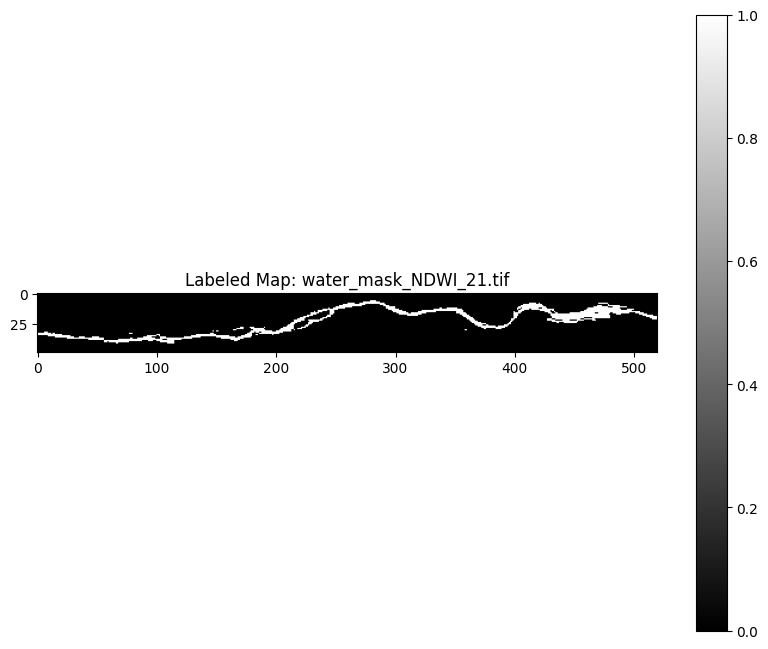

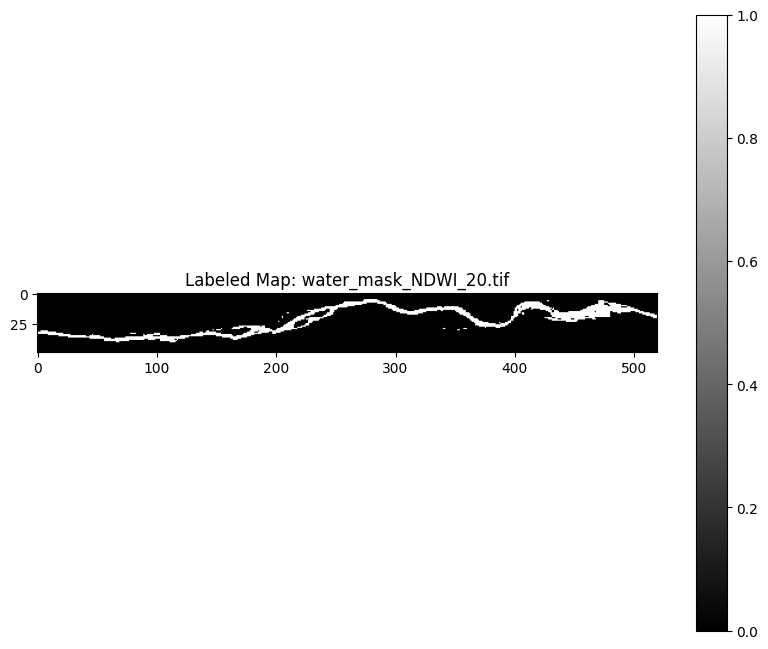

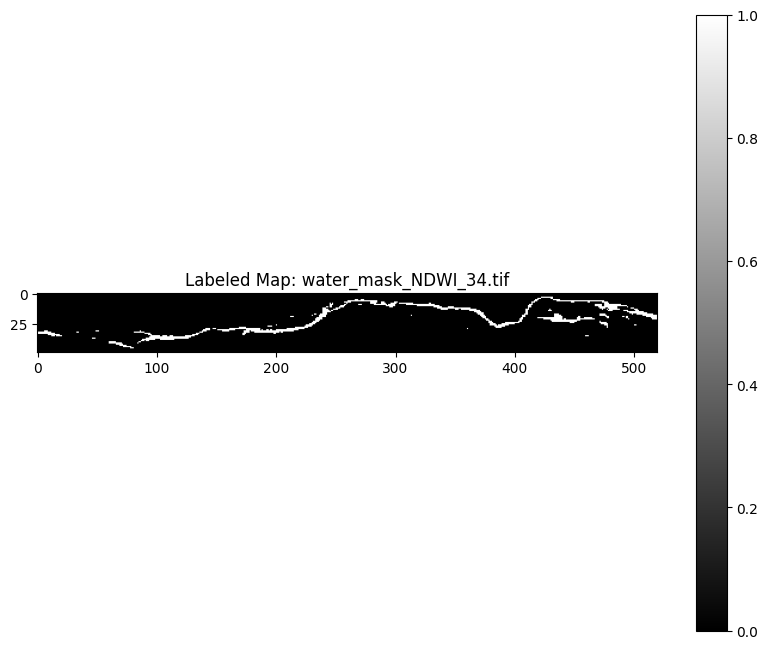

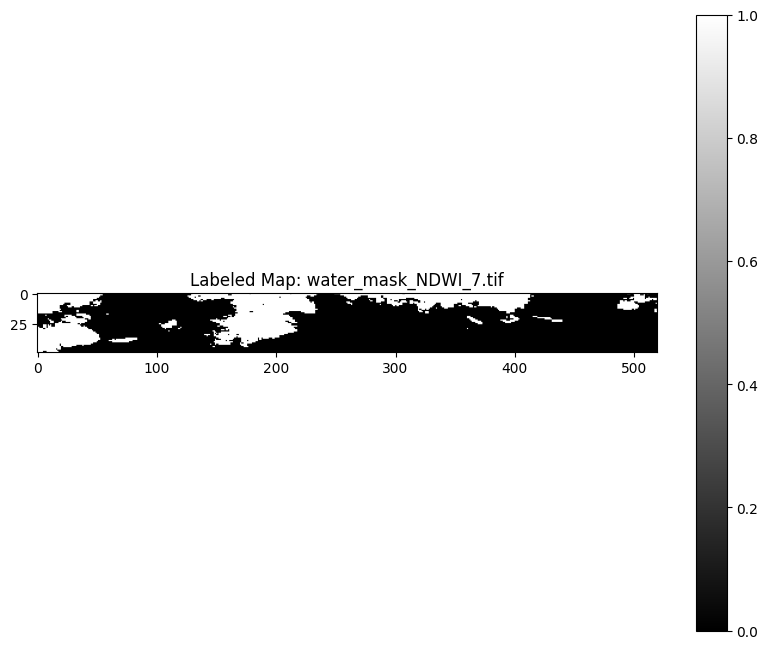

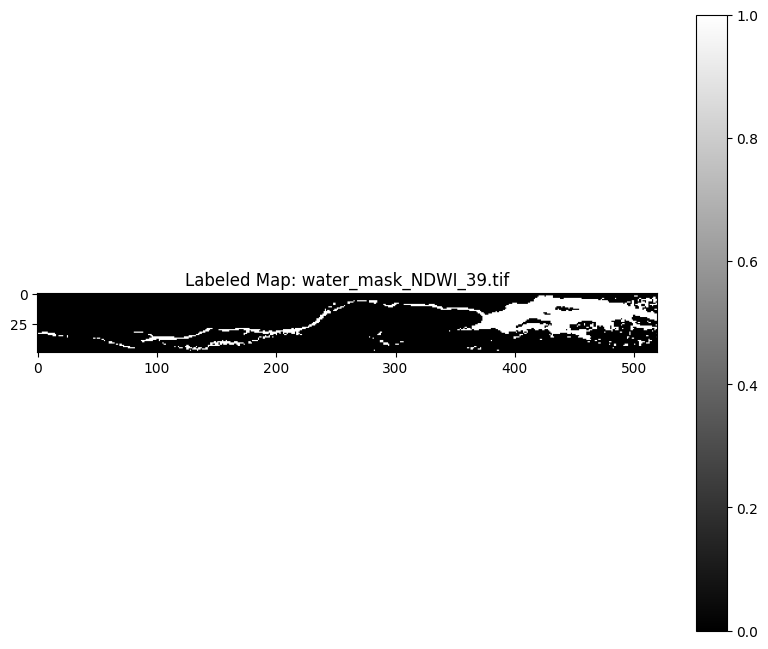

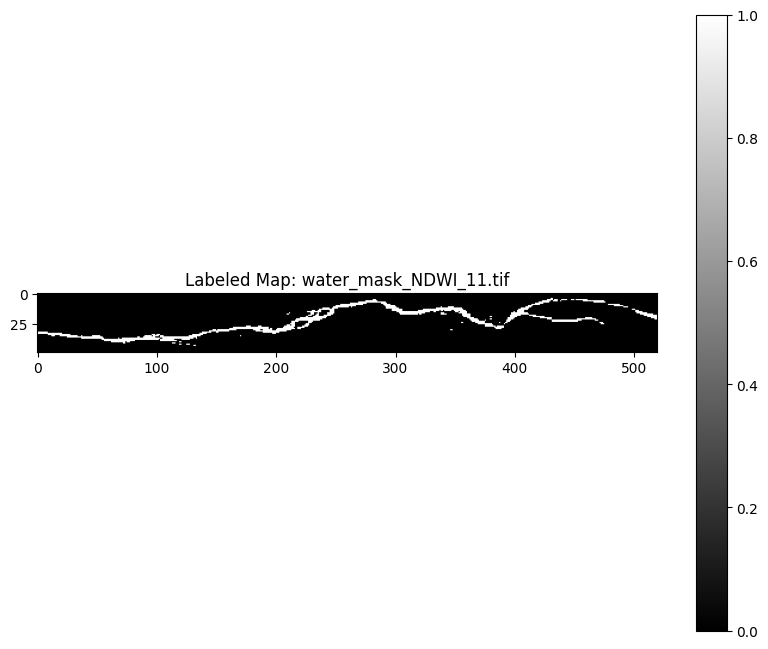

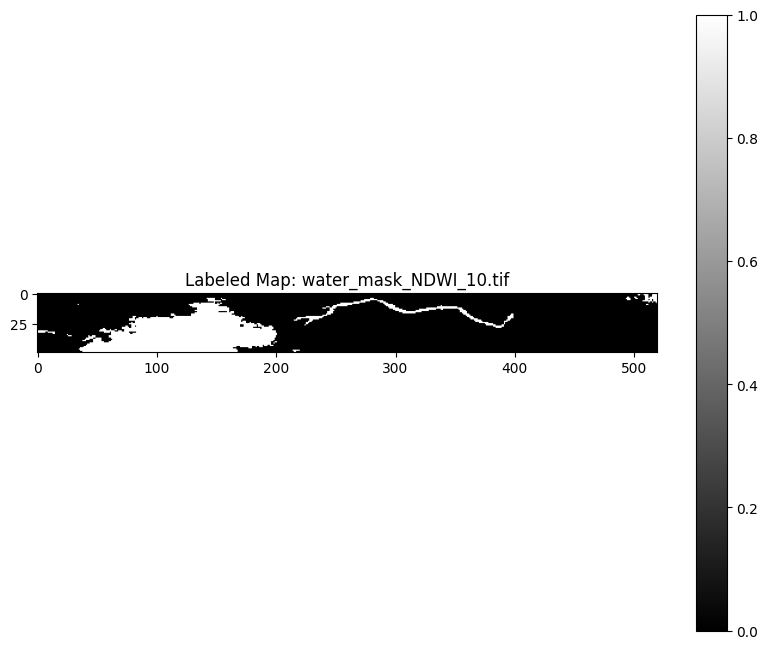

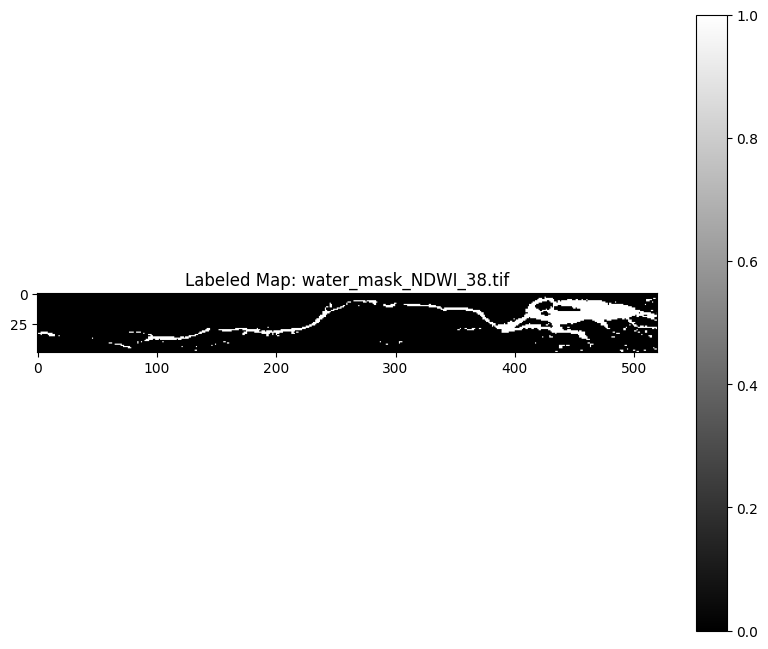

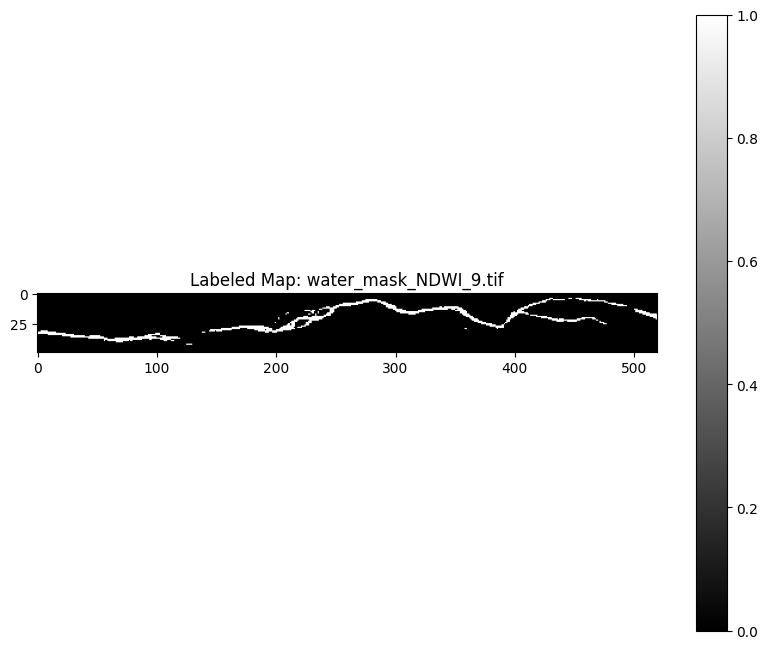

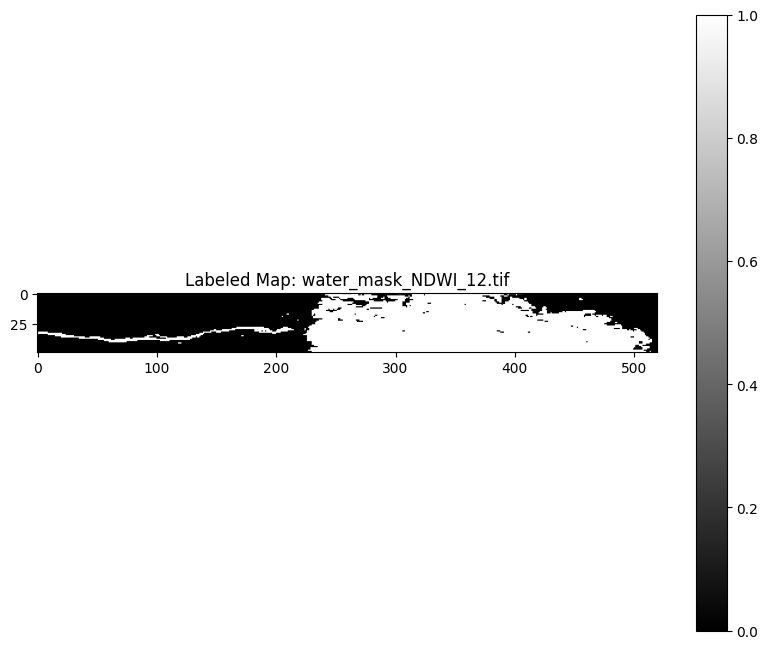

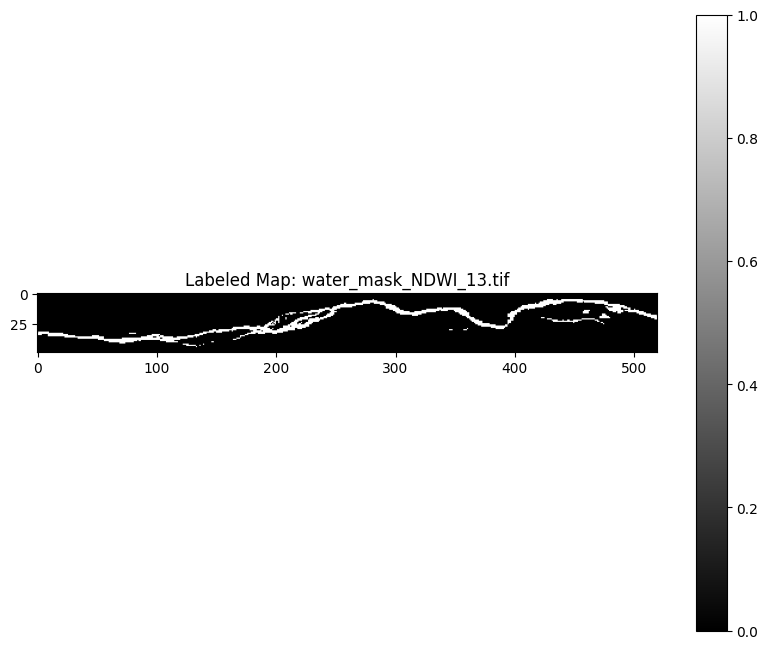

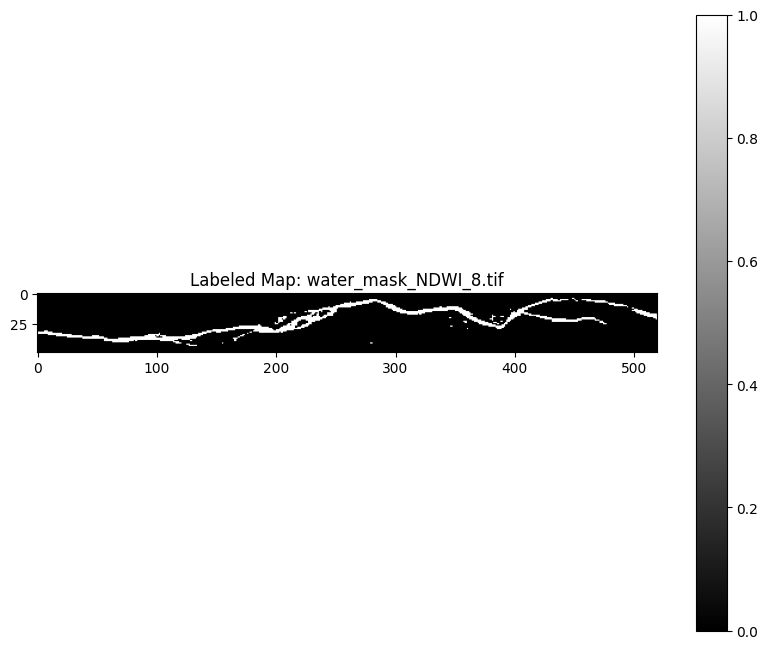

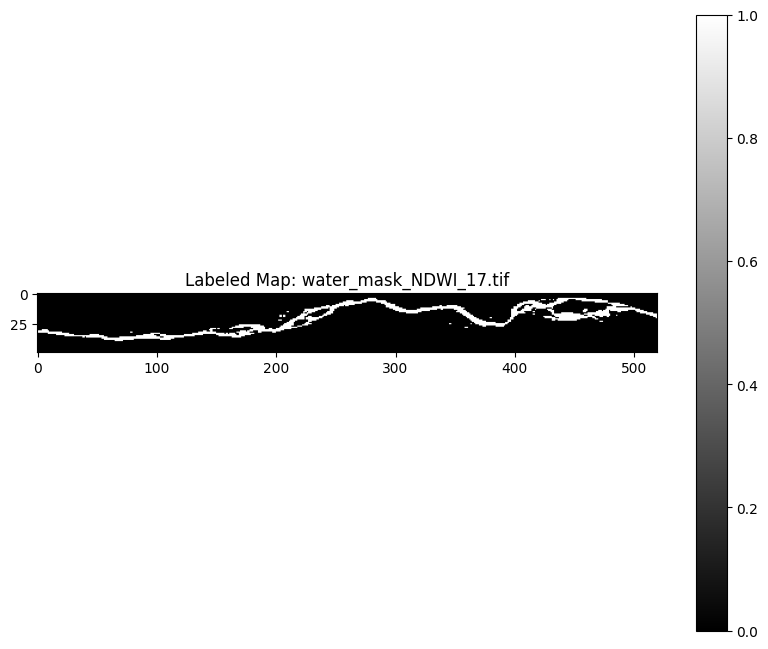

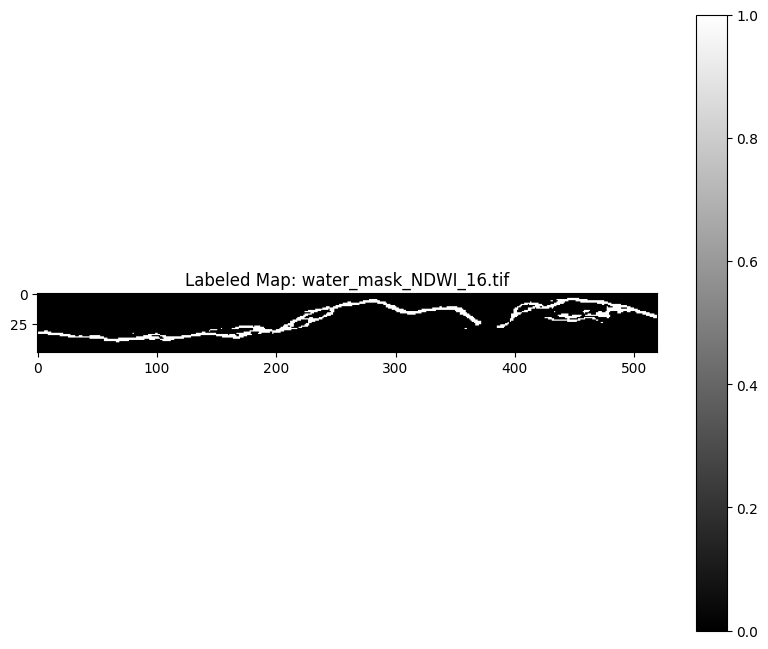

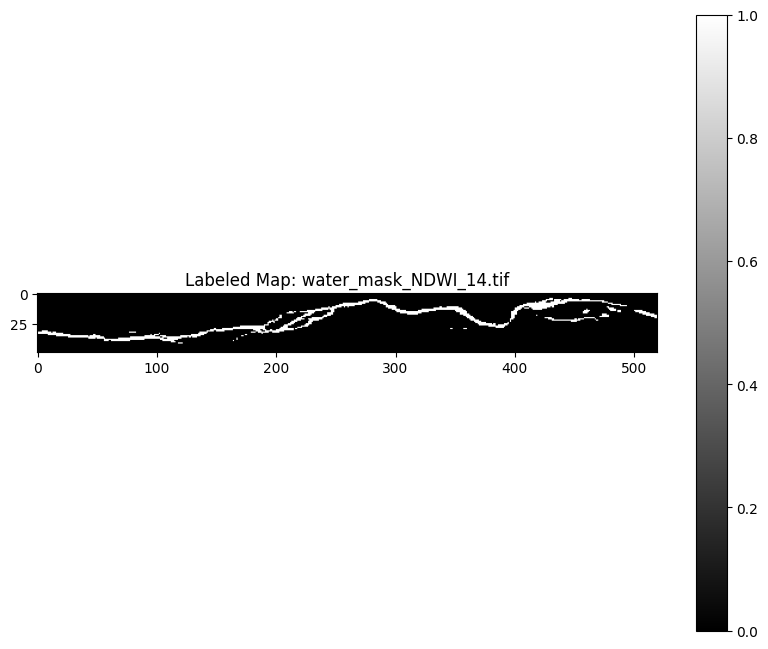

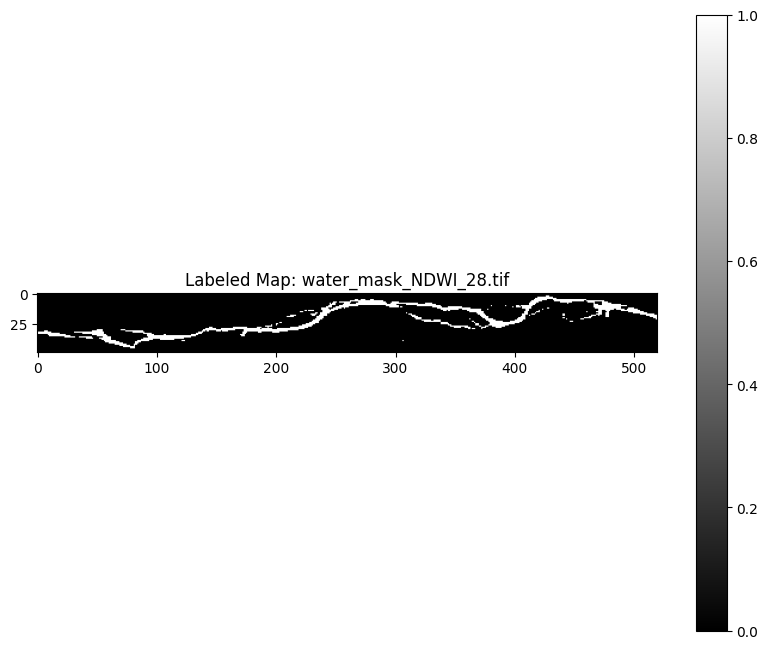

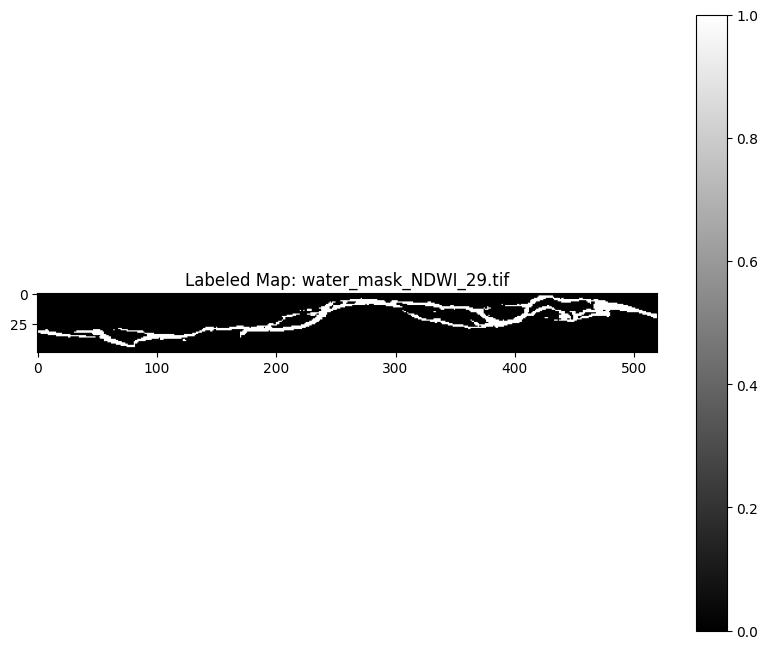

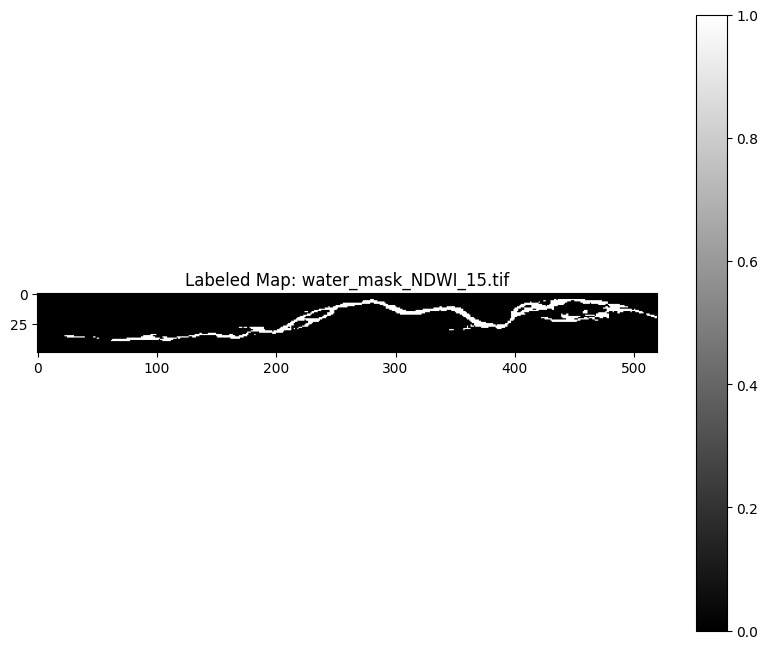

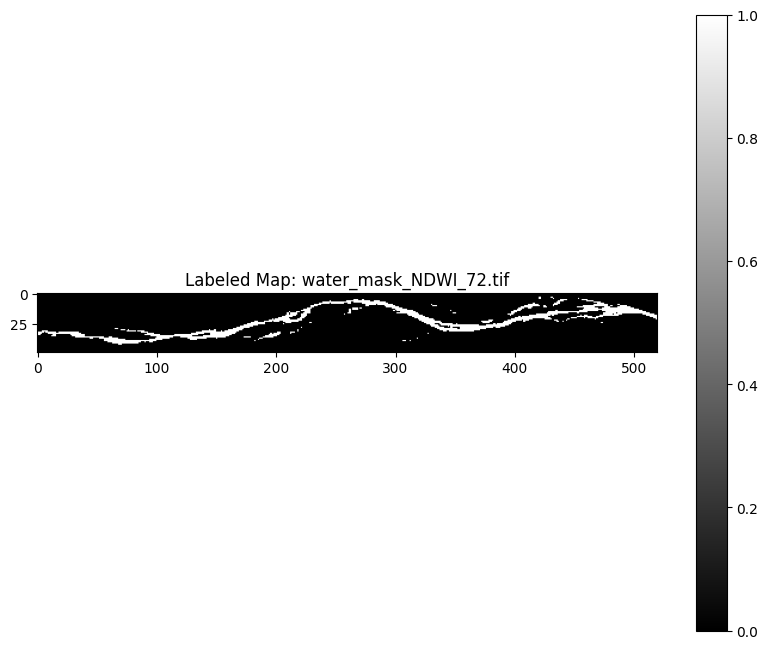

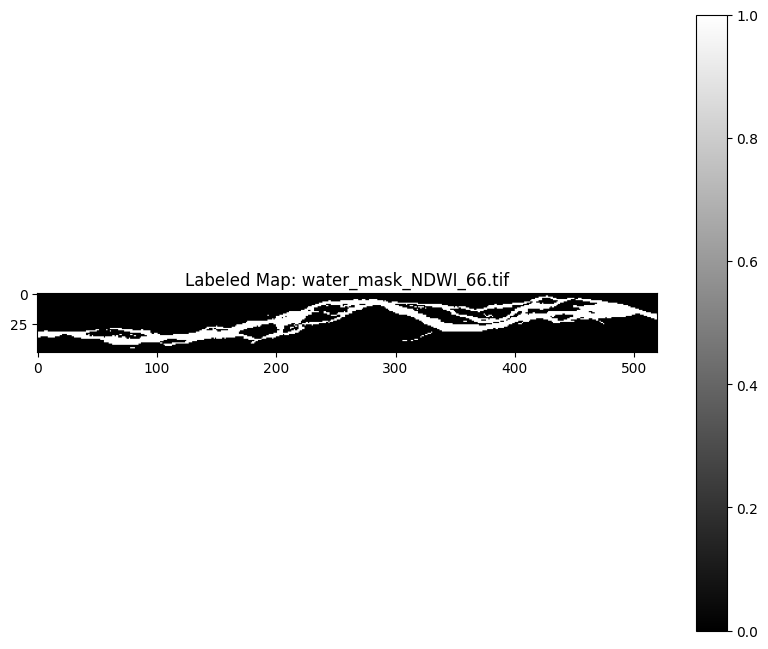

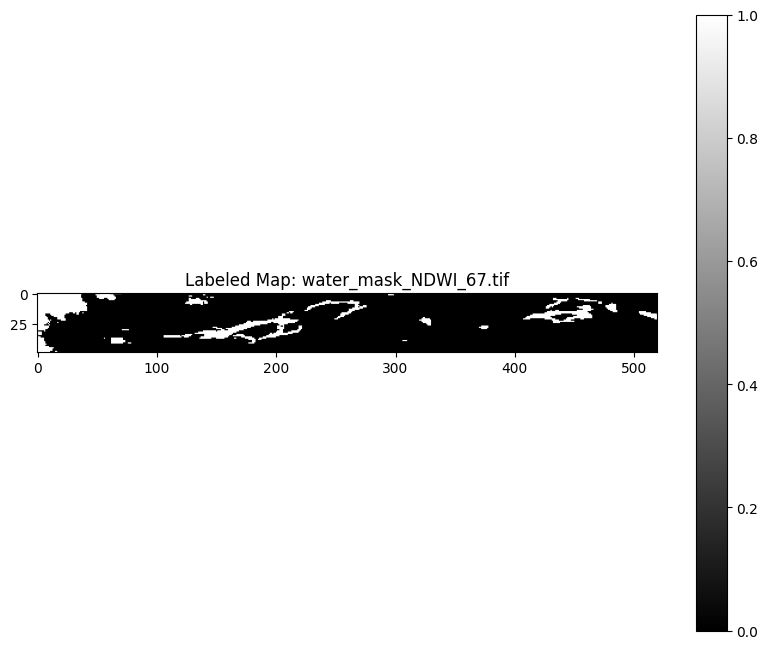

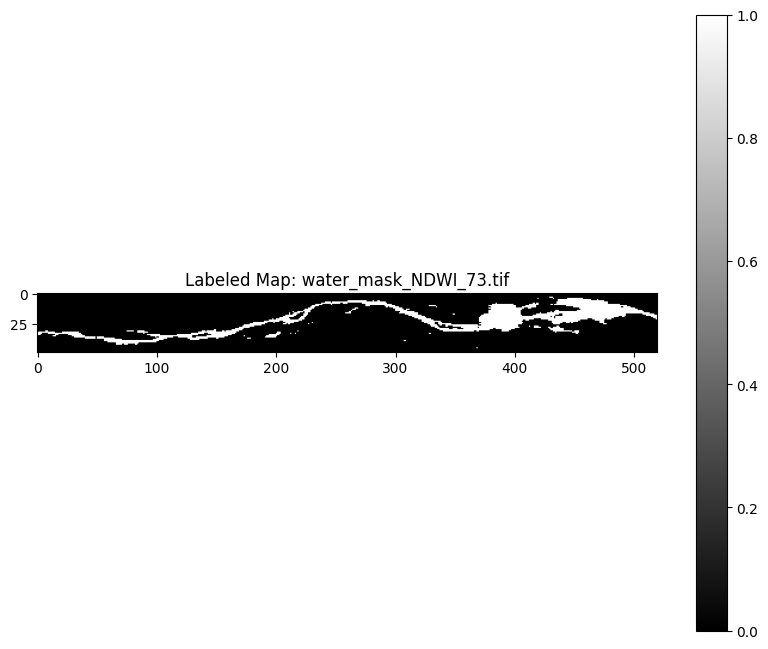

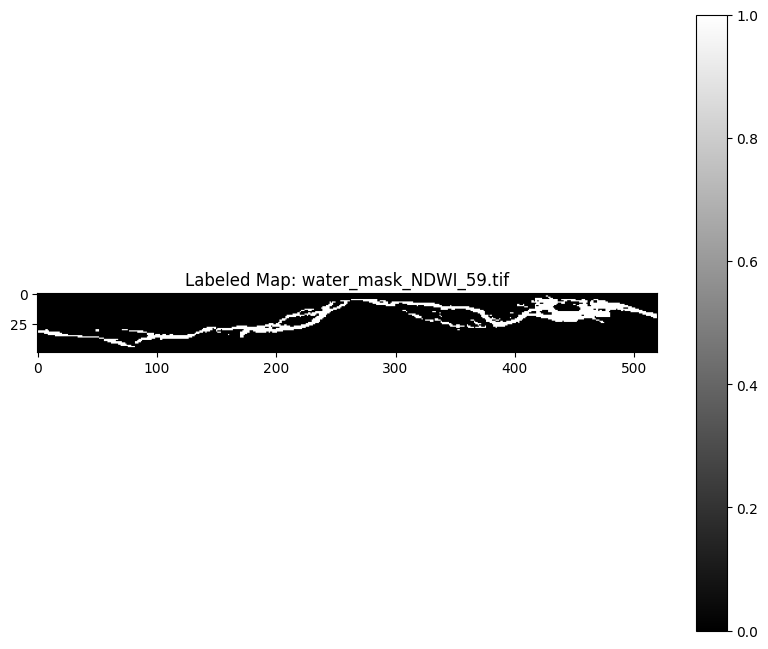

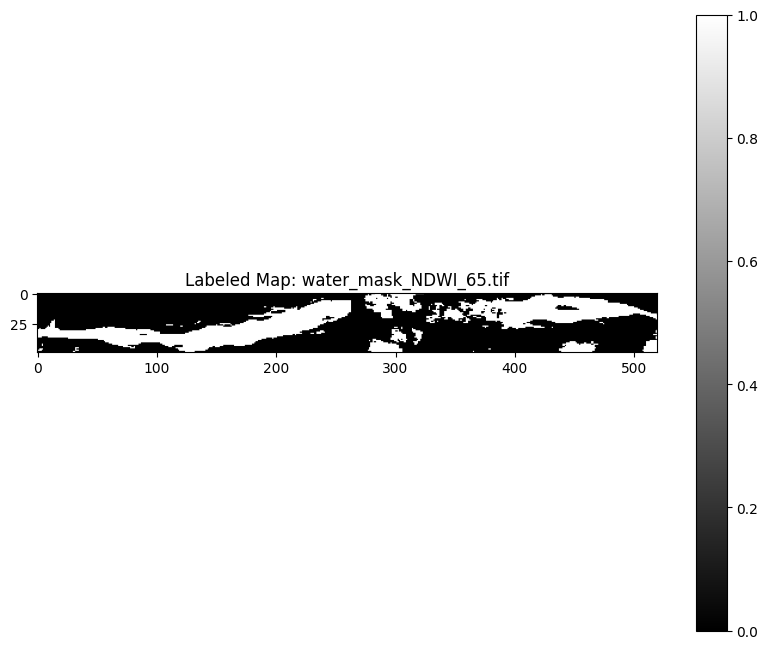

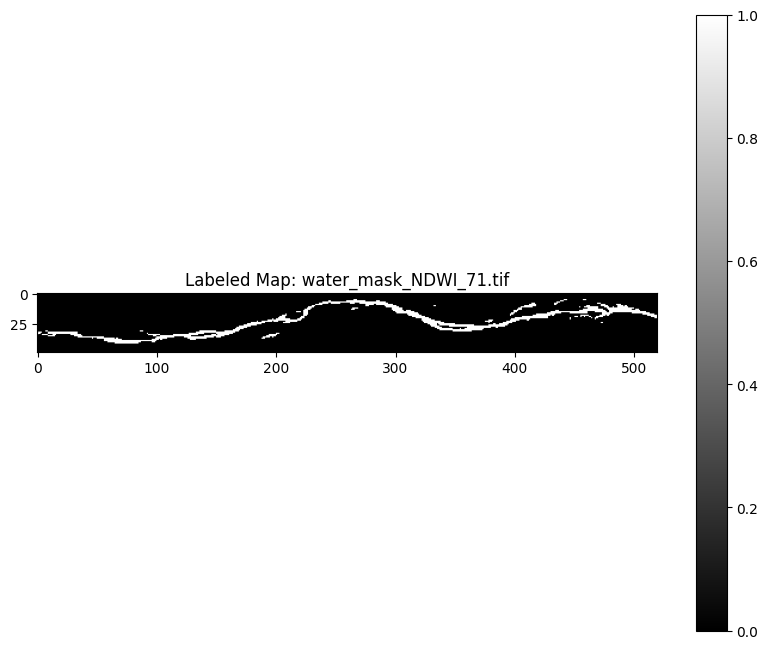

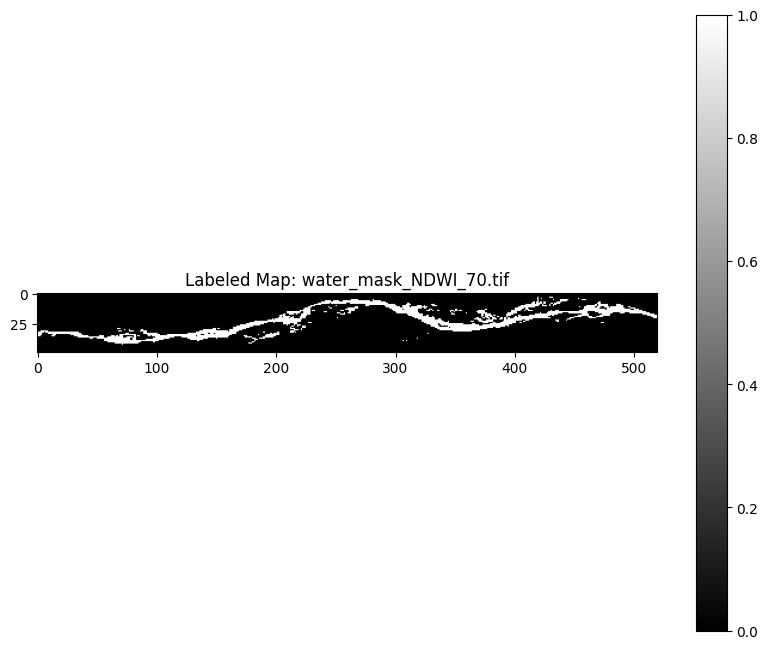

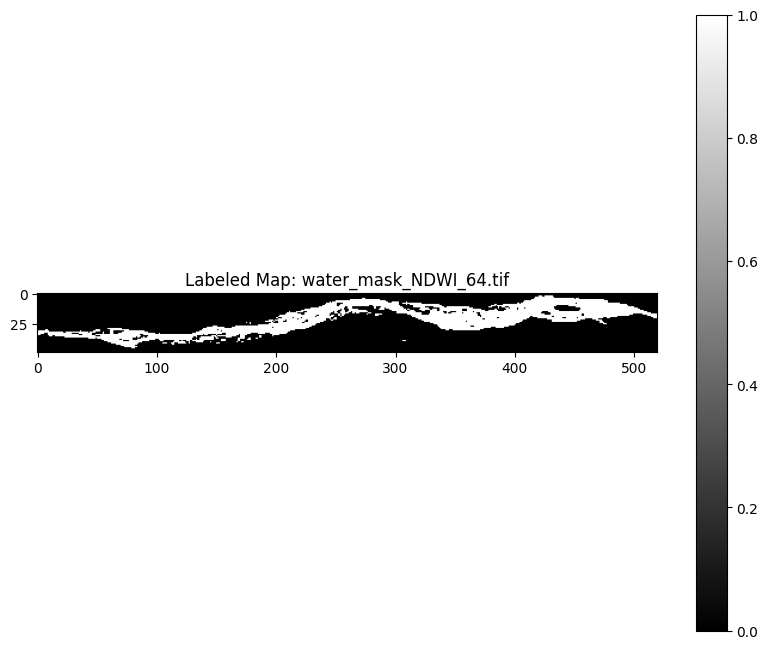

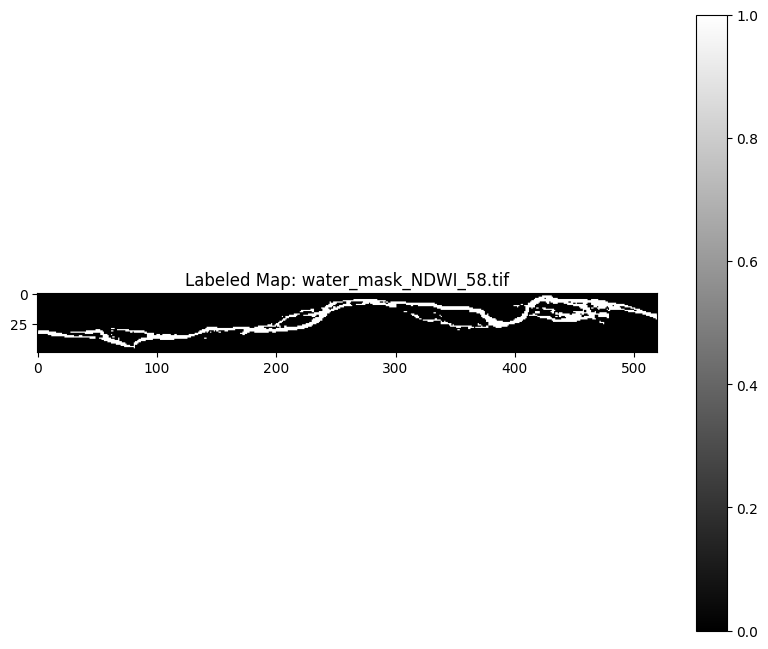

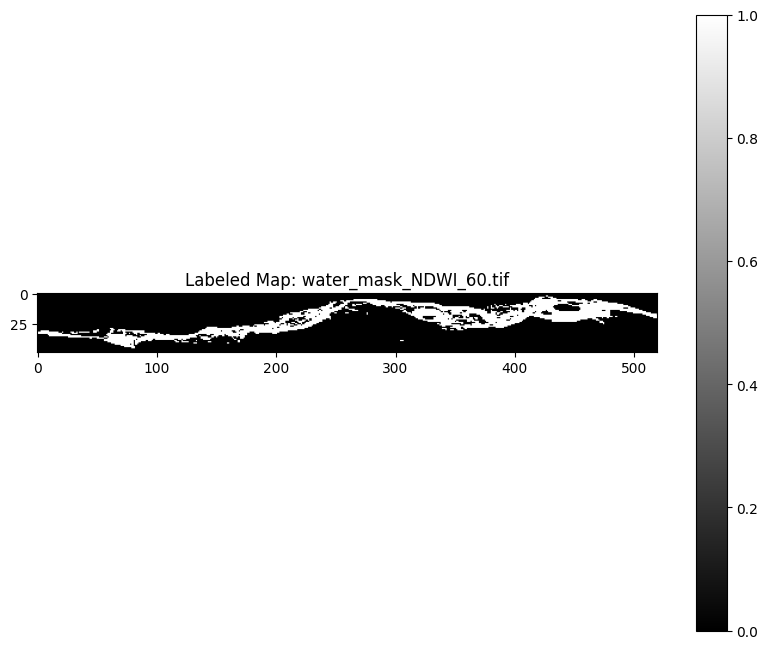

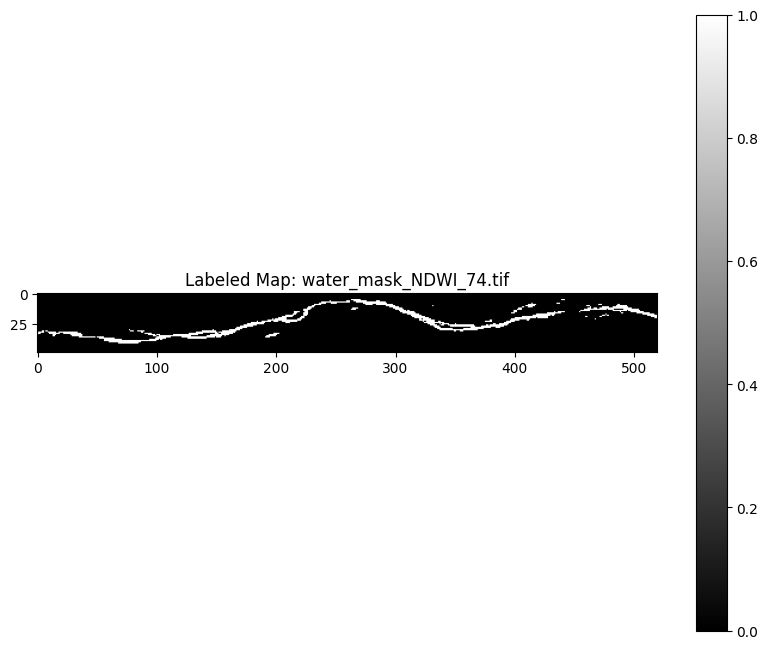

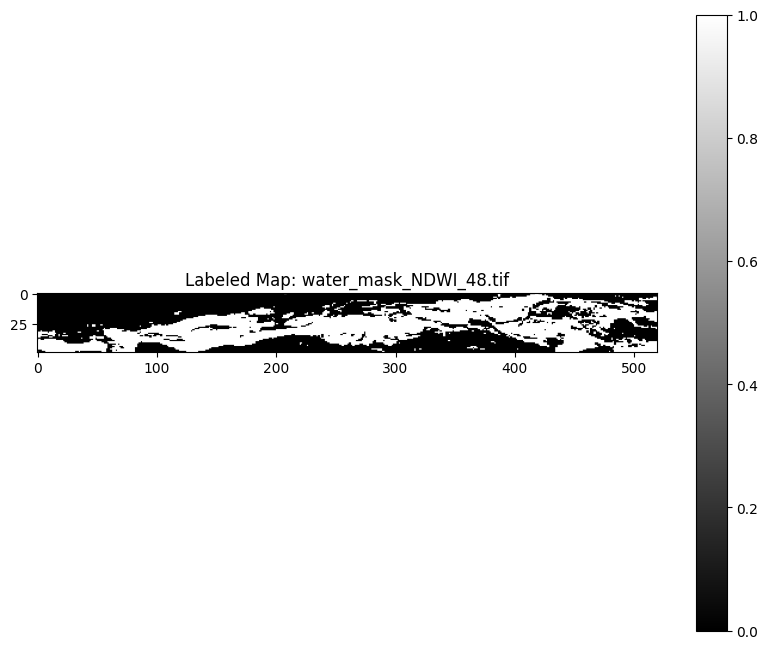

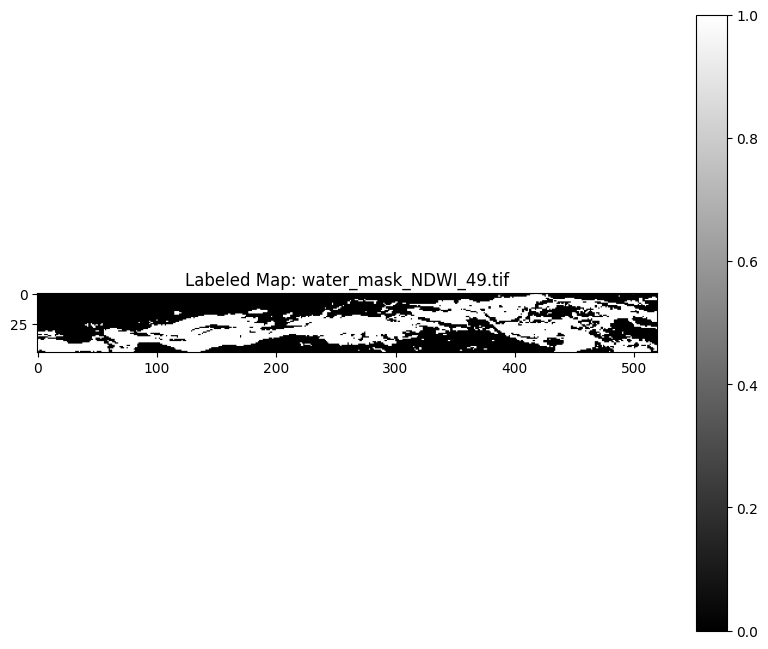

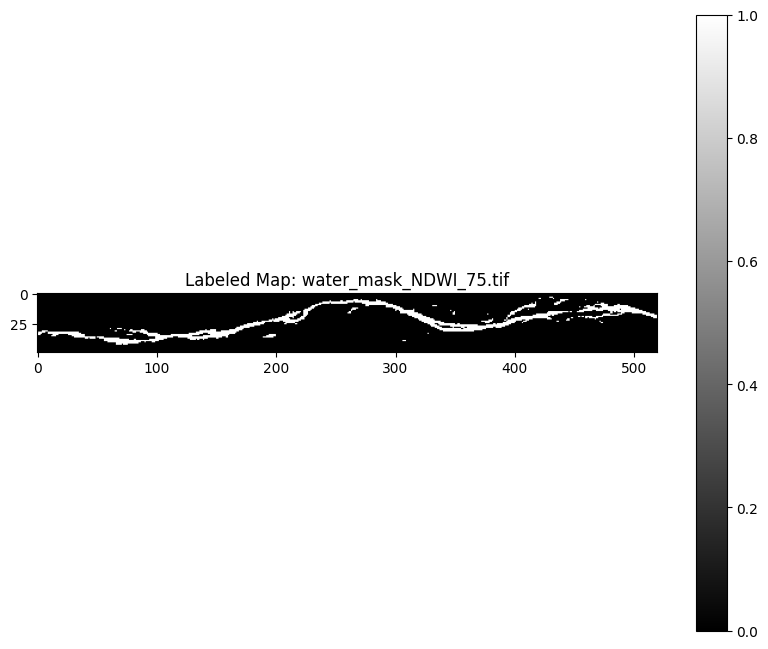

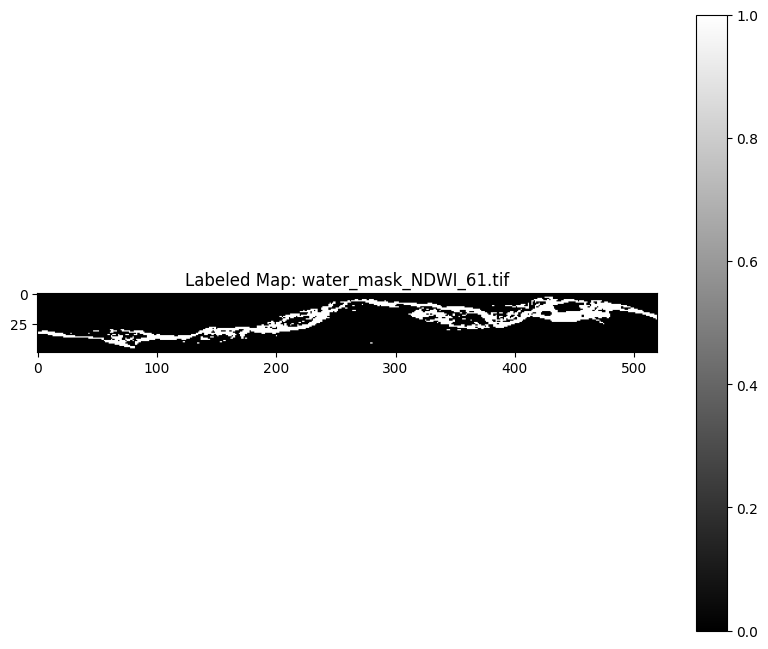

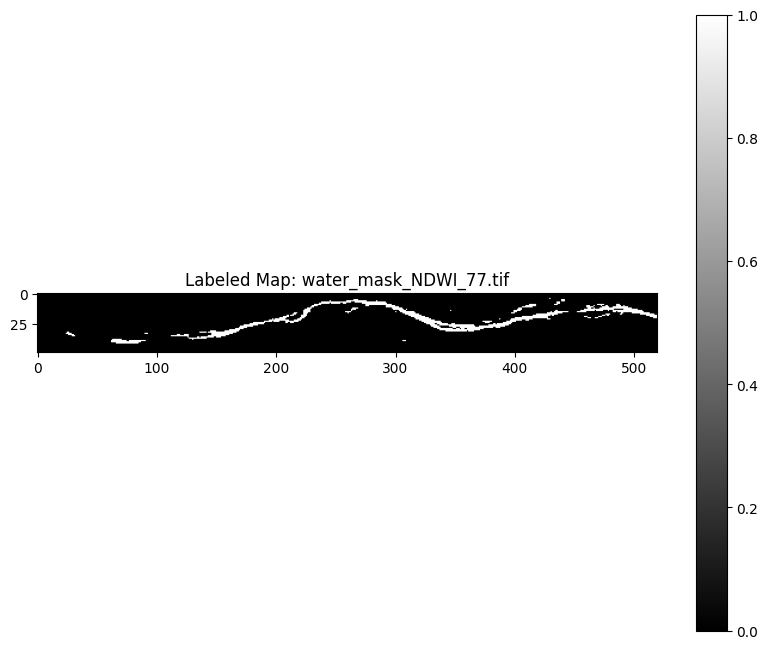

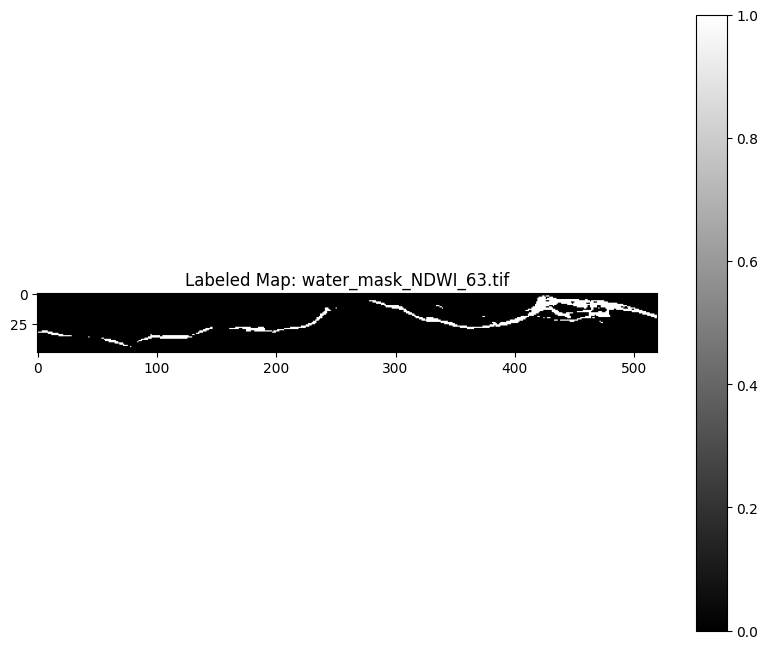

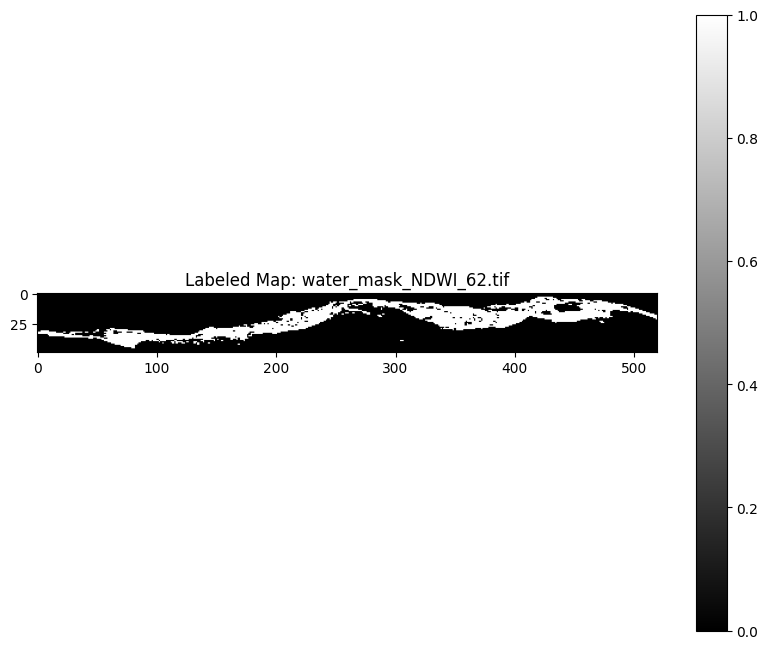

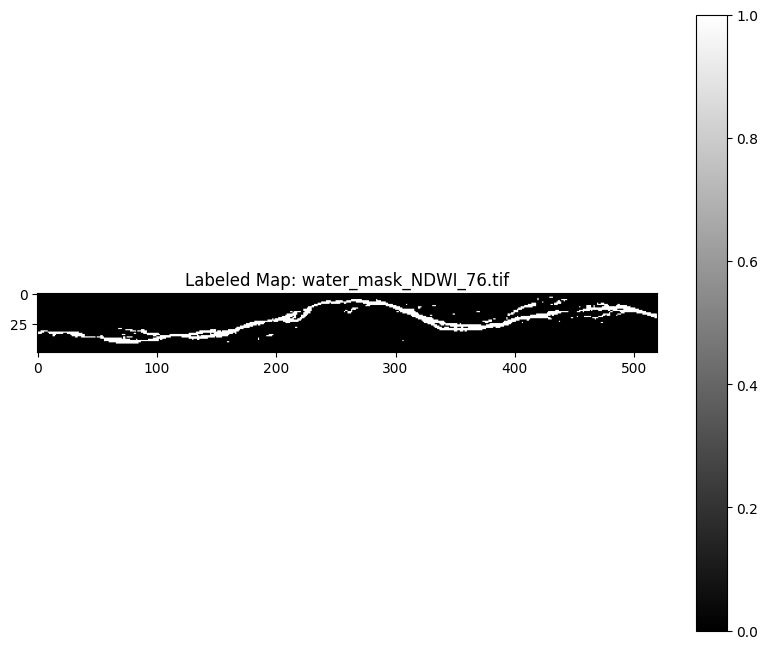

Es wurden 80 Labeled Maps geladen.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
from osgeo import gdal

# Pfad zu deinem Ordner mit den Labeled Maps
folder_path = 'water_masks/'

# Hole alle TIF-Dateien im Ordner
tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.tif')]

# Erstelle eine Liste für die Labeled Maps
labeled_maps = []

# Durchlaufe alle TIF-Dateien und lade sie als Labeled Maps
for tif_file in tif_files:
    file_path = os.path.join(folder_path, tif_file)
    
    try:
        # Öffne das Bild mit gdal
        dataset = gdal.Open(file_path)
        
        # Hole die erste Band (Labeled Map)
        band = dataset.GetRasterBand(1)
        
        # Lese die Bilddaten als NumPy Array
        image_data = band.ReadAsArray()
        
        # Füge die Labeled Map der Liste hinzu
        labeled_maps.append(image_data)
        
        # Zeige das Bild an
        plt.figure(figsize=(10, 8))
        plt.imshow(image_data, cmap='gray')  # Annahme: Es handelt sich um binäre Labeled Maps
        plt.title(f"Labeled Map: {tif_file}")
        plt.colorbar()
        plt.show()
        
        # Schließe das Dataset
        dataset = None
        
    except Exception as e:
        print(f"Fehler beim Laden von {tif_file}: {str(e)}")

# Optional: Wenn du alle Labeled Maps in einem Array hast und mit ihnen weiterarbeiten willst
labeled_maps_array = np.array(labeled_maps)

print(f"Es wurden {len(labeled_maps)} Labeled Maps geladen.")


In [16]:
import numpy as np
import pandas as pd
import os
import rasterio
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import zoom

# Step 1: Lade alle .tif-Dateien und lade sie als binäre Masken
def load_labeled_maps(tif_folder):
    labeled_maps = []
    filenames = sorted([f for f in os.listdir(tif_folder) if f.endswith('.tif')])
    
    for filename in filenames:
        file_path = os.path.join(tif_folder, filename)
        with rasterio.open(file_path) as src:
            data = src.read(1)  # Nur das erste Band lesen
            binary_mask = np.where(data > 0, 1, 0)  # Binärmaske erstellen (1 für Gewässer, 0 für nicht)
            labeled_maps.append(binary_mask)
    
    return np.array(labeled_maps)

# Step 2: Lade die Tabelle, die ID und Timestamp verbindet
def load_metadata(metadata_path):
    metadata = pd.read_csv(metadata_path)
    return metadata

# Schritt 3: Lade die .tif-Dateien als Labeled Maps und die Tabelle mit den Timestamps
tif_folder = 'Labeled_Maps_Isar/'  # Pfad zum Ordner mit den .tif-Dateien
metadata_path = 'Metadata_with_index.csv'  # Pfad zur CSV-Datei mit den IDs und Timestamps

# Labeled Maps laden
labeled_maps = load_labeled_maps(tif_folder)

# Stelle sicher, dass die Form des Arrays korrekt ist (80 x 49 x 520)
labeled_maps = labeled_maps.reshape(80, 49, 520, 1)  # Hinzufügen eines Kanal-Dimension für CNN

# Lade die Metadata und verbinde IDs mit Timestamps
metadata = load_metadata(metadata_path)




/Users/evaschmidt/Documents/Preprocessing_SatelliteImagery/river_analysis_env/lib/python3.11/site-packages/numpy/_core/_dtype.py:106: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if dtype.type == np.bool:


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [21]:
# Beispiel: Exogene Faktoren (z. B. kumulierter Discharge und Precipitation)
# Hier musst du die Exogenen Faktoren entsprechend deiner Tabelle einlesen
# Angenommen, die Tabelle hat Spalten "discharge" und "precipitation"

exogenous_df = pd.read_csv('exo_factors.csv')  # Pfad zu deiner Tabelle mit den exogenen Faktoren
#exogenous_df = table[['image_id', 'timestamp', 'discharge_cum', 'precipitation_cum_mm']].values  # Spalten aus Metadata extrahieren

exogenous_df['Discharge'] = pd.to_numeric(exogenous_df['discharge_cum'], errors='coerce')
exogenous_df['Precipitation'] = pd.to_numeric(exogenous_df['precipitation_cum_mm'], errors='coerce')

# 3. Optional: NaN-Werte behandeln (hier: ersetzen durch 0)
exogenous_df['Discharge'].fillna(0, inplace=True)
exogenous_df['Precipitation'].fillna(0, inplace=True)

exogenous_factors = exogenous_df[['Discharge', 'Precipitation']].values

print(exogenous_factors)
print(exogenous_factors.dtype)  # Sollte nun ein numerisches Format wie float64 sein


# Optional: Normalisiere die exogenen Faktoren
#exogenous_factors = exogenous_factors / np.max(exogenous_factors, axis=0)

# Labels (hier als binär, 1 für Gewässer, 0 für kein Gewässer)
labels = labeled_maps  # Deine Labels sind bereits in labeled_maps enthalten


[[ 9860.79  6048.4 ]
 [ 9868.31  6048.4 ]
 [ 9879.41  6048.4 ]
 [ 9886.82  6048.4 ]
 [ 9897.93  6048.4 ]
 [ 9923.68  6068.5 ]
 [ 9941.47  6070.7 ]
 [ 9999.08  6149.7 ]
 [10008.35  6149.7 ]
 [10054.97  6172.1 ]
 [10068.32  6172.4 ]
 [10076.86  6181.2 ]
 [10119.92  6186.2 ]
 [10177.68  6292.9 ]
 [10271.83  6336.  ]
 [10332.65  6336.  ]
 [10342.92  6336.  ]
 [10357.57  6336.  ]
 [10369.34  6336.  ]
 [10449.66  6406.1 ]
 [10463.36  6410.6 ]
 [10472.2   6422.5 ]
 [10629.72  6533.2 ]
 [10653.23  6533.2 ]
 [10661.4   6533.7 ]
 [10695.25  6575.8 ]
 [10703.76  6575.8 ]
 [10724.95  6583.3 ]
 [10775.95  6652.1 ]
 [10793.85  6680.1 ]
 [10818.54  6680.1 ]
 [10827.82  6680.1 ]
 [10841.89  6680.1 ]
 [10851.45  6689.6 ]
 [11091.36  6889.  ]
 [11099.78  6889.  ]
 [11120.23  6889.  ]
 [11132.19  6891.6 ]
 [11153.04  6898.5 ]
 [11161.15  6898.5 ]
 [11172.51  6898.5 ]
 [11251.72  6949.4 ]
 [11259.16  6949.4 ]
 [11341.87  6969.9 ]
 [11358.88  6994.  ]
 [11466.45  7050.8 ]
 [11485.44  7052.8 ]
 [11497.11  7

/var/folders/y9/ftz5q33d4yv1x_392gz2zk6c0000gn/T/ipykernel_13793/1724679474.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  exogenous_df['Discharge'].fillna(0, inplace=True)
/var/folders/y9/ftz5q33d4yv1x_392gz2zk6c0000gn/T/ipykernel_13793/1724679474.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [13]:
exogenous_factors.shape

(80, 4)

In [26]:
#funktioniert

def build_cnn_lstm_model(input_shape, exogenous_input_shape):
    # CNN-Part für räumliche Merkmalsextraktion
    cnn_input = layers.Input(shape=input_shape)  # (49, 520, 1) für Grayscale-Bilder
    x = layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    
    # Exogene Faktoren (z. B. kumulierter Discharge und Precipitation)
    exogenous_input = layers.Input(shape=exogenous_input_shape)  # z. B. (2,) für 2 exogene Faktoren
    exogenous_dense = layers.Dense(64, activation='relu')(exogenous_input)

    # Kombiniere CNN-Features und exogene Eingaben
    combined = layers.concatenate([x, exogenous_dense])
    
    # LSTM-Part für zeitliche Abhängigkeiten
    lstm_input = layers.Reshape((1, combined.shape[1]))(combined)  # Reshape für LSTM
    lstm = layers.LSTM(128, return_sequences=True)(lstm_input)
    lstm = layers.LSTM(64)(lstm)
    
    # Dense Layer für finale Vorhersage
    #output = layers.Dense(1, activation='sigmoid')(lstm)
    #output = layers.Conv2D(1, (1, 1), activation='sigmoid')(lstm)
    output = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(x)

    
    # Modelldefinition
    model = models.Model(inputs=[cnn_input, exogenous_input], outputs=output)
    
    return model

# Eingabe-Datenformate
input_shape = (49, 520, 1)  # Beispiel für Grayscale-Bilder
exogenous_input_shape = (2,)  # z. B. kumulierter Discharge und Precipitation

# Modell bauen
model = build_cnn_lstm_model(input_shape, exogenous_input_shape)

# Modell kompilieren
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Modell zusammenfassen
model.summary()


ValueError: Input 0 of layer "conv3d" is incompatible with the layer: expected min_ndim=5, found ndim=2. Full shape received: (None, 32256)

In [29]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def build_cnn_lstm_model(input_shape, exogenous_input_shape):
    # CNN-Part für räumliche Merkmalsextraktion
    cnn_input = layers.Input(shape=input_shape)  # (49, 520, 1) für Grayscale-Bilder
    x = layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    
    # Exogene Faktoren (z. B. kumulierter Discharge und Precipitation)
    exogenous_input = layers.Input(shape=exogenous_input_shape)  # z. B. (4,) für 4 exogene Faktoren
    exogenous_dense = layers.Dense(64, activation='relu')(exogenous_input)

    # Kombiniere CNN-Features und exogene Eingaben
    combined = layers.concatenate([x, exogenous_dense])
    
    # Reshape der kombinierten Daten auf eine Form, die für Conv3D geeignet ist
    combined_reshaped = layers.Reshape((1, 1, combined.shape[1], 1))(combined)  # (1, 1, combined_dim, 1) für Conv3D
    
    # Verwende Conv3D für zeitliche und räumliche Merkmalsextraktion
    x = layers.Conv3D(64, (1, 1, 3), activation='relu')(combined_reshaped)
    x = layers.Conv3D(128, (1, 1, 3), activation='relu')(x)
    
    # Die Ausgabe für jedes Pixel im Bild
    output = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(x)
    
    # Modelldefinition
    model = models.Model(inputs=[cnn_input, exogenous_input], outputs=output)
    
    return model

# Eingabe-Datenformate
input_shape = (49, 520, 1)  # Beispiel für Grayscale-Bilder
exogenous_input_shape = (2,)  # 4 exogene Faktoren (z.B. discharge, precipitation)

# Modell bauen
model = build_cnn_lstm_model(input_shape, exogenous_input_shape)

# Modell kompilieren
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Modell zusammenfassen
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 49, 520,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 47, 518,   │        320 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 23, 259,   │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 21, 257,   │     18,496 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 10, 128,   │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 8, 126,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 4, 63,     │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 32256)     │          0 │ max_pooling2d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │        192 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 32320)     │          0 │ flatten_5[0][0],  │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1, 1,      │          0 │ concatenate_5[0]… │
│                     │ 32320, 1)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 1, 1,      │        256 │ reshape_5[0][0]   │
│                     │ 32318, 64)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 1, 1,      │     24,704 │ conv3d_4[0][0]    │
│                     │ 32316, 128)       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 1, 1,      │        129 │ conv3d_5[0][0]    │
│                     │ 32316, 1)         │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 117,953 (460.75 KB)

 Trainable params: 117,953 (460.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

##funktioniert

def build_cnn_lstm_model(input_shape, exogenous_input_shape):
    # CNN-Part für räumliche Merkmalsextraktion
    cnn_input = layers.Input(shape=input_shape)  # (49, 520, 1) für Grayscale-Bilder
    x = layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    
    # Exogene Faktoren (z. B. kumulierter Discharge und Precipitation)
    exogenous_input = layers.Input(shape=exogenous_input_shape)  # z. B. (4,) für 4 exogene Faktoren
    exogenous_dense = layers.Dense(64, activation='relu')(exogenous_input)

    # Kombiniere CNN-Features und exogene Eingaben
    combined = layers.concatenate([x, exogenous_dense])
    
    # Dense Layer für finale Vorhersage
    output = layers.Dense(input_shape[0] * input_shape[1], activation='sigmoid')(combined)
    output = layers.Reshape((input_shape[0], input_shape[1], 1))(output)  # Form auf (49, 520, 1) umformen
    
    # Modelldefinition
    model = models.Model(inputs=[cnn_input, exogenous_input], outputs=output)
    
    return model

# Eingabe-Datenformate
input_shape = (49, 520, 1)  # Beispiel für Grayscale-Bilder
exogenous_input_shape = (2,)  # 4 exogene Faktoren (z.B. discharge, precipitation)

# Modell bauen
model = build_cnn_lstm_model(input_shape, exogenous_input_shape)

# Modell kompilieren
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Modell zusammenfassen
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 49, 520,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 47, 518,   │        320 │ input_layer_13[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 23, 259,   │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 21, 257,   │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 10, 128,   │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 8, 126,    │     73,856 │ max_pooling2d_19… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 4, 63,     │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 32256)     │          0 │ max_pooling2d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │        192 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 32320)     │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 25480)     │ 823,539,0… │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 49, 520,   │          0 │ dense_9[0][0]     │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 823,631,944 (3.07 GB)

 Trainable params: 823,631,944 (3.07 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit([labeled_maps, exogenous_factors], labels, epochs=10, batch_size=4)

Epoch 1/10
 3/20 ━━━━━━━━━━━━━━━━━━━━ 18:42 66s/step - accuracy: 0.5327 - loss: 7.0101

In [10]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import zoom

folder_path = 'Labeled_Maps_Isar/'  # Pfad zu deinen .tif Dateien

# Listet alle .tif-Dateien auf
file_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith('.tif')]

# Lese die .tif Dateien und speichere sie in einem numpy Array
labeled_maps = []
for file_path in file_paths:
    dataset = gdal.Open(file_path)
    if dataset is None:
        continue  # überspringe, wenn Datei nicht geöffnet werden konnte

    band = dataset.GetRasterBand(1)
    image_data = band.ReadAsArray()
    
    # Sicherstellen, dass die Werte binär sind (0 oder 1)
    image_data = np.where(image_data > 0, 1, 0)
    
    labeled_maps.append(image_data)

# Konvertiere in numpy Array
labeled_maps = np.array(labeled_maps)


In [ ]:
Natürlich! Lass uns Schritt für Schritt durchgehen, wie du die Tabelle mit den exogenen Faktoren aufbaust und wie du die Zeitkomponente (einschließlich LSTM) in das Modell integrierst.

### 1. **Struktur der Tabelle mit den exogenen Faktoren**

Die Tabelle mit den exogenen Faktoren enthält typischerweise die Zeitstempel und verschiedene Merkmale (z. B. kumulierten Abfluss und Niederschlag). Sie muss so strukturiert sein, dass du die **Zeitkomponente** (d.h. für welchen Zeitpunkt du die exogenen Faktoren hast) und die **numerischen Werte** für die Merkmale (z. B. Abfluss und Niederschlag) korrekt zuordnen kannst.

#### Beispiel für eine Tabelle mit exogenen Faktoren:

| timestamp           | id   | discharge_cum | precipitation_cum_mm |
|---------------------|------|---------------|----------------------|
| 2023-01-01 00:00:00 | 1    | 1000          | 50                   |
| 2023-01-01 01:00:00 | 2    | 1200          | 55                   |
| 2023-01-01 02:00:00 | 3    | 1400          | 60                   |
| ...                 | ...  | ...           | ...                  |

**Erklärung der Spalten:**
- **timestamp**: Der Zeitpunkt der Messung (z. B. stündlich oder täglich).
- **id**: Eine eindeutige Kennung für jede Zeile (optional, könnte als Index verwendet werden).
- **discharge_cum**: Der kumulierte Abfluss.
- **precipitation_cum_mm**: Der kumulierte Niederschlag in Millimetern.

**Wichtige Punkte**:
- Die **Zeitstempel** sind sehr wichtig, weil sie die Reihenfolge der Daten festlegen.
- Nur die **numerischen Spalten** (z. B. `discharge_cum`, `precipitation_cum_mm`) werden später als exogene Faktoren in das Modell eingegeben.

### 2. **Vorbereitung der exogenen Faktoren**

Da du eine Zeitreihe von Bildern und exogenen Faktoren hast, musst du sicherstellen, dass du für jedes Bild und den entsprechenden exogenen Faktor für den Zeitpunkt `t` die **exogenen Faktoren der gleichen Zeitreihe** (`t`) verwendest.

Wenn du den Datensatz mit den exogenen Faktoren hast, dann könntest du ihn folgendermaßen vorbereiten:

1. **Extrahiere nur die numerischen Spalten** (d.h. Abfluss, Niederschlag).
2. **Verkette sie mit den Zeitstempeln**, damit du immer weißt, für welchen Zeitpunkt du welche Daten hast.

Hier ist ein Beispiel, wie du die exogenen Faktoren vorbereiten kannst:

```python
import pandas as pd

# Tabelle mit den exogenen Faktoren
table = pd.read_csv('exo_factors.csv')  # Lade die Tabelle

# Wähle nur die numerischen Spalten aus
exogenous_df = table[['timestamp', 'discharge_cum', 'precipitation_cum_mm']]

# Umwandeln der numerischen Spalten in den richtigen Datentyp
exogenous_df['discharge_cum'] = pd.to_numeric(exogenous_df['discharge_cum'], errors='coerce')
exogenous_df['precipitation_cum_mm'] = pd.to_numeric(exogenous_df['precipitation_cum_mm'], errors='coerce')

# Optional: NaN-Werte behandeln
exogenous_df.fillna(0, inplace=True)

# Die exogenen Faktoren (wir brauchen nur die numerischen Spalten)
exogenous_factors = exogenous_df[['discharge_cum', 'precipitation_cum_mm']].values
```

### 3. **Zeitkomponente mit LSTM einbringen**

Um die **Zeitkomponente** in das Modell zu integrieren, benötigst du eine **LSTM-Schicht** (Long Short-Term Memory), die gut geeignet ist, um Zeitabhängigkeiten zu modellieren. LSTM-Schichten sind ideal, um sequentielle Daten zu verarbeiten, also auch Zeitreihen wie deine.

**LSTM** benötigt jedoch Daten im Format `(batch_size, time_steps, features)`, wobei:
- `batch_size` die Anzahl der Datenproben in einem Batch ist.
- `time_steps` die Anzahl der Zeitschritte (z. B. Stunden, Tage).
- `features` die Anzahl der Merkmale ist, die du für jeden Zeitschritt hast (z. B. Abfluss und Niederschlag).

#### Aufbau des Modells mit LSTM:

1. **LSTM für exogene Faktoren**: Um die exogenen Faktoren (die für jede Stunde oder Tag angegeben sind) als Zeitreihe zu verwenden, musst du sie in einer **3D-Form** aufbereiten. Das bedeutet, dass du sie mit einer `LSTM`-Schicht verwenden kannst.
   
2. **Bilddaten und Zeitreihen kombinieren**: Du kannst die CNN-Ausgabe (die das Bild verarbeitet) mit der LSTM-Ausgabe (die die exogenen Faktoren verarbeitet) kombinieren, um die nächste Labeled Map vorherzusagen.

Hier ist ein Beispiel für die Modellarchitektur:

```python
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def build_cnn_lstm_forecast_model(input_shape, exogenous_input_shape, time_steps):
    # CNN für die Bildverarbeitung
    cnn_input = layers.Input(shape=input_shape)  # (49, 520, 1) für Grayscale-Bilder
    x = layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    
    # Exogene Faktoren als Zeitreihe (LSTM)
    exogenous_input = layers.Input(shape=(time_steps, exogenous_input_shape))  # z.B. (5, 2) für 5 Zeitstempel und 2 Merkmale
    exogenous_lstm = layers.LSTM(64)(exogenous_input)

    # Kombinieren der CNN- und LSTM-Ausgabe
    combined = layers.concatenate([x, exogenous_lstm])

    # Dense Layer für finale Vorhersage der nächsten Labeled Map
    output = layers.Dense(input_shape[0] * input_shape[1], activation='sigmoid')(combined)
    output = layers.Reshape((input_shape[0], input_shape[1], 1))(output)  # Umformen zu (49, 520, 1)
    
    # Modell definieren
    model = models.Model(inputs=[cnn_input, exogenous_input], outputs=output)
    
    return model

# Beispiel: Eingabeformate und Zeitstempel
input_shape = (49, 520, 1)  # z.B. für Grayscale-Bilder
exogenous_input_shape = 2  # z.B. 2 Merkmale: discharge_cum und precipitation_cum_mm
time_steps = 5  # Angenommen, wir verwenden die letzten 5 Zeitschritte der exogenen Faktoren

# Modell erstellen
model = build_cnn_lstm_forecast_model(input_shape, exogenous_input_shape, time_steps)

# Modell kompilieren
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Modell zusammenfassen
model.summary()
```

### 4. **Datenaufbereitung für Zeitreihen**

Für das Training des Modells solltest du die exogenen Faktoren im **Zeitreihenformat** aufbereiten:

```python
# Angenommen, du hast `exogenous_factors` mit einer Form von (n_samples, 2)
# Wir müssen die Daten für LSTM in ein 3D-Format umwandeln: (n_samples, time_steps, features)

time_steps = 5  # Beispiel: Wir verwenden die letzten 5 Zeitschritte

# Um die Zeitreihe zu erstellen, verschiebe die exogenen Faktoren um `time_steps`
exogenous_input = []
for i in range(time_steps, len(exogenous_factors)):
    exogenous_input.append(exogenous_factors[i-time_steps:i])  # Die letzten 5 Zeitschritte
exogenous_input = np.array(exogenous_input)

# Labeled Maps (Ziel) ist das Bild der nächsten Zeitstufe
y_labels = labeled_maps[time_steps:]  # Wir verwenden die Labeled Maps ab `t+1`
```

### Zusammenfassung der Schritte:

1. **Exogene Faktoren aufbereiten**: Stelle sicher, dass du nur die numerischen Merkmale wie `discharge_cum` und `precipitation_cum_mm` verwendest.
2. **LSTM für Zeitreihen**: Du musst sicherstellen, dass du die exogenen Faktoren in einer **3D-Form** (zeitliche Dimension) hast, sodass sie von einem LSTM verarbeitet werden können.
3. **Modellaufbau**: Baue ein Modell mit einem CNN-Teil für die Bildverarbeitung und einem LSTM-Teil für die exogenen Faktoren.
4. **Datenaufbereitung**: Bereite die Daten so vor, dass du die letzten `time_steps` der exogenen Faktoren für jedes Trainingseintrag verwendest und die Labeled Map des nächsten Zeitpunkts als Ziel nutzt.

Ich hoffe, das hilft dir weiter! Lass es mich wissen, wenn du noch Fragen hast.

In [1]:
import rasterio
import numpy as np
import os
import glob

def load_tif_image(file_path):
    with rasterio.open(file_path) as src:
        # Bilddaten laden (als numpy-Array)
        image = src.read(1)  # Hier nehmen wir den ersten Band des Bildes (Grayscale)
        image = np.expand_dims(image, axis=-1)  # Wir fügen eine zusätzliche Dimension hinzu, falls nötig
    return image

# Funktion, um alle .tif Bilder aus einem Verzeichnis zu laden
def load_all_tif_images(directory):
    image_paths = glob.glob(os.path.join(directory, "*.tif"))
    images = []
    for path in image_paths:
        image = load_tif_image(path)
        images.append(image)
    return np.array(images)

# Beispiel: Lade alle Bilder aus einem Verzeichnis
images_directory = "Labeled_Maps_Isar/"
images = load_all_tif_images(images_directory)


In [2]:
import pandas as pd

# CSV mit den exogenen Faktoren laden
exo_factors_df = pd.read_csv("exo_factors.csv")

# Stellen wir sicher, dass der Datentyp korrekt ist
exo_factors_df['timestamp'] = pd.to_datetime(exo_factors_df['timestamp'])
exo_factors_df['discharge_cum'] = pd.to_numeric(exo_factors_df['discharge_cum'], errors='coerce')
exo_factors_df['precipitation_cum_mm'] = pd.to_numeric(exo_factors_df['precipitation_cum_mm'], errors='coerce')

exo_factors_df = exo_factors_df[['timestamp', 'image_id', 'discharge_cum', 'precipitation_cum_mm']]
# NaN-Werte auffüllen (falls notwendig)
exo_factors_df.fillna(0, inplace=True)

# Nun haben wir die exogenen Faktoren als DataFrame
print(exo_factors_df.head())


   timestamp  image_id  discharge_cum  precipitation_cum_mm
0 2020-04-01         0        9860.79                6048.4
1 2020-04-03         1        9868.31                6048.4
2 2020-04-06         2        9879.41                6048.4
3 2020-04-08         3        9886.82                6048.4
4 2020-04-11         4        9897.93                6048.4


In [3]:
# Umwandlung der exogenen Faktoren in ein NumPy-Array (nur die numerischen Spalten)
exo_factors = exo_factors_df[['discharge_cum', 'precipitation_cum_mm']].values

# Falls du sie normalisieren oder anpassen möchtest (optional)
# Zum Beispiel:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# exo_factors = scaler.fit_transform(exo_factors)

# Jetzt hast du ein NumPy-Array mit der Form (n_samples, 2), welches du für das Training verwenden kannst
print(exo_factors.shape)

(80, 2)


In [4]:
import tensorflow as tf
import numpy as np

def data_generator(images, exo_factors, batch_size, time_steps=5):
    while True:  # Endlos-Schleife, damit der Generator unendlich weiterläuft
        indices = np.random.choice(len(images) - time_steps, batch_size)

        X_images_batch = []  # List für die Batches der Eingabebilder
        exogenous_batch = []  # List für die Batches der exogenen Faktoren
        Y_image_batch = []  # List für die Batches der Zielbilder

        for idx in indices:
            # Erstelle das Batch aus den letzten `time_steps` Bildern
            X_images_batch.append(images[idx:idx+time_steps])
            
            # Erstelle das Batch aus den letzten `time_steps` exogenen Faktoren
            exogenous_batch.append(exo_factors[idx:idx+time_steps])

            # Das Ziel ist das Bild bei `t+1` (also nach den `time_steps`)
            Y_image_batch.append(images[idx + time_steps])

        # Um die richtigen Formen zu erhalten, konvertieren wir Listen in Numpy-Arrays
        X_images_batch = np.array(X_images_batch)
        exogenous_batch = np.array(exogenous_batch)
        Y_image_batch = np.array(Y_image_batch)

        X_images_batch = np.expand_dims(X_images_batch, axis=-1)  # Hinzufügen des Kanals für die Eingabebilder
        Y_image_batch = np.expand_dims(Y_image_batch, axis=-1)  # Hinzufügen des Kanals für die Zielbilder


        # Jetzt konvertieren wir die Arrays in Tensoren
        
        # Gib das Batch als Tensoren zurück
        yield (
            (tf.convert_to_tensor(X_images_batch, dtype=tf.float32),
             tf.convert_to_tensor(exogenous_batch, dtype=tf.float32)),
            tf.convert_to_tensor(Y_image_batch, dtype=tf.float32)
        )


In [5]:
def get_output_signature(images, exo_factors, time_steps=5):
    return (
        (tf.TensorSpec(shape=(None, time_steps, *images.shape[1:]), dtype=tf.float32),  # Eingabebilder
         tf.TensorSpec(shape=(None, time_steps, exo_factors.shape[1]), dtype=tf.float32)),  # Exogene Faktoren
        tf.TensorSpec(shape=(None, *images.shape[1:]), dtype=tf.float32)  # Zielbilder
    )

In [11]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def build_cnn_lstm_model(image_shape, exo_input_shape, time_steps):
    # CNN für die Bildverarbeitung (jetzt mit Conv3D und valid padding)
    cnn_input = layers.Input(shape=(time_steps, *image_shape))  # z.B. (5, 49, 520, 1)
    x = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='valid')(cnn_input)  # Weniger Filter und valid Padding
    x = layers.MaxPooling3D((1, 2, 2), padding='valid')(x)  # Pooling mit valid Padding, kleinere Pooling-Größe
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='valid')(x)  # Weniger Filter und valid Padding
    x = layers.MaxPooling3D((1, 2, 2), padding='valid')(x)  # Pooling mit valid Padding, kleinere Pooling-Größe
    x = layers.Flatten()(x)  # Flatten der Ausgabe für die Fully Connected Layer
    
    # LSTM für die exogenen Faktoren
    exo_input = layers.Input(shape=(time_steps, exo_input_shape))  # z.B. (5, 2) für 5 Zeitstempel und 2 Merkmale
    exo_lstm = layers.LSTM(16)(exo_input)  # Weniger LSTM-Einheiten

    # Kombinieren der CNN- und LSTM-Ausgabe
    combined = layers.concatenate([x, exo_lstm])

    # Dense Layer für finale Vorhersage des nächsten Bildes
    output = layers.Dense(image_shape[0] * image_shape[1], activation='sigmoid')(combined)
    output = layers.Reshape((image_shape[0], image_shape[1], 1))(output)  # Umformen zu (49, 520, 1)
    
    # Modell definieren
    model = models.Model(inputs=[cnn_input, exo_input], outputs=output)
    
    return model

# Beispiel: Eingabeformate und Zeitstempel
image_shape = (49, 520, 1)  # z.B. für Grayscale-Bilder
exo_input_shape = 2  # z.B. 2 Merkmale: discharge_cum und precipitation_cum_mm
time_steps = 5  # Angenommen, wir verwenden die letzten 5 Zeitschritte der exogenen Faktoren

# Modell erstellen
model = build_cnn_lstm_model(image_shape, exo_input_shape, time_steps)

# Modell kompilieren
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Modell zusammenfassen
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 5, 49,     │          0 │ -                 │
│ (InputLayer)        │ 520, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 3, 47,     │        224 │ input_layer_8[0]… │
│                     │ 518, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_8     │ (None, 3, 23,     │          0 │ conv3d_8[0][0]    │
│ (MaxPooling3D)      │ 259, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 1, 21,     │      3,472 │ max_pooling3d_8[… │
│                     │ 257, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_9     │ (None, 1, 10,     │          0 │ conv3d_9[0][0]    │
│ (MaxPooling3D)      │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 5, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 20480)     │          0 │ max_pooling3d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 16)        │      1,216 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 20496)     │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 25480)     │ 522,263,5… │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 49, 520,   │          0 │ dense_4[0][0]     │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 522,268,472 (1.95 GB)

 Trainable params: 522,268,472 (1.95 GB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Beispiel für das Training
train_generator = data_generator(images, exo_factors, batch_size=32, time_steps=5)

# Modell trainieren
model.fit(train_generator, 
          steps_per_epoch=len(images)//32, 
          epochs=10)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 138s 94s/step - accuracy: 0.6575 - loss: 0.6483
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 190s 91s/step - accuracy: 0.9685 - loss: 0.3617
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 185s 96s/step - accuracy: 0.9703 - loss: 0.1598
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 179s 89s/step - accuracy: 0.9689 - loss: 0.1217
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 197s 101s/step - accuracy: 0.9691 - loss: 0.1357
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 186s 99s/step - accuracy: 0.9705 - loss: 0.1353
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 174s 84s/step - accuracy: 0.9708 - loss: 0.1275
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 172s 86s/step - accuracy: 0.9738 - loss: 0.1050
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 174s 86s/step - accuracy: 0.9709 - loss: 0.1216
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 779s 114s/step - accuracy: 0.9702 - loss: 0.1100


In [13]:
# Save the entire model (architecture, weights, and training configuration)
model.save('model/baseline_model.h5')
